In [4]:
from epymorph import *
from epymorph.compartment_model import *
from epymorph.initializer import single_location

from epymorph.geo import *
from epymorph.geo.geo import Geo
from epymorph.geo.adrio import adrio_maker_library
from epymorph.geo.adrio.census.adrio_census import CensusGeography, Granularity
from epymorph.util import pairwise_haversine, row_normalize
from epymorph.geo.cache import save_to_cache
from epymorph.geo.dynamic import DynamicGeo
from epymorph.cli.run import save_csv

from epymorph.geo.cache import load_from_cache

In [6]:
import matplotlib.patches as mpatches
from pyvis.network import Network
from pygris import block_groups 
import matplotlib.pyplot as plt
from functools import partial
import geopandas as gpd
from PIL import Image
import networkx as nx
import pandas as pd
import mapclassify
import numpy as np
import requests
import gzip
import time
import ast
import os
import re


data = geo_library['movement_geo']().values
geo = pd.DataFrame({k: list(v) for k, v in data.items()})

dir = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/gifs')


In [233]:
data = geo_library['movement_geo']().values
geo = pd.DataFrame({k: list(v) for k, v in data.items()})

In [234]:
sdh_df = pd.DataFrame({k: list(v) for k, v in data.items()})


In [235]:
geoid_value = '040134223021'
selected_row = sdh_df[sdh_df['geoid'] == geoid_value]

# Display the selected row with all its columns
if not selected_row.empty:
    print(selected_row)
else:
    print(f"No row found with geoid = {geoid_value}")

                                       centroid         geoid         label  \
1820  [-111.80141612966149, 33.385925714693485]  040134223021  040134223021   

      population                                   school_commuters  
1820         538  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [236]:
sdh_df['population'].max()

538

In [8]:
maricopa = block_groups(state="AZ", county="Maricopa", year=2019, cache=False)
maricopa_base = maricopa.copy()

Using FIPS code '04' for input 'AZ'
Using FIPS code '013' for input 'Maricopa'


In [34]:
model_path = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/gifs/epymorph_model.csv')


Running simulation (StandardSimulation):
• 2019-07-20 to 2020-03-28 (252 days)
• 2494 geo nodes
|####################| 100% 
Runtime: 252.664s


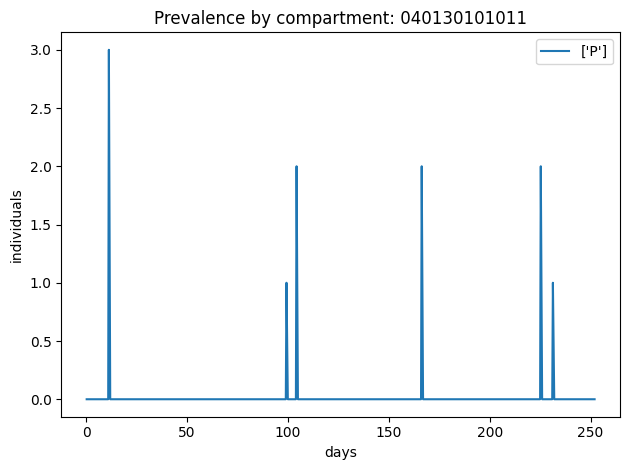

In [316]:
phi = 50
sim = StandardSimulation(
        geo =  geo_library['movement_geo'](),
        ipm = ipm_library['no'](),
        mm = mm_library['centroids'](),
        params={
            'beta_s': 2.5,
            'beta_v': 0.3,
            'alpha': 20, 
            'gamma': 10,
            'omega': 0.0000023,
            'sigma': 0.12,  
            'phi': phi,
        },
        time_frame=TimeFrame.of("2019-07-20", 252),
        initializer=partial(single_location, location=0, seed_size=0)
    )

with sim_messaging(sim):
    output = sim.run()
plot_pop(output, pop_idx=0)

single_simulation_out = f'/Users/alexandernez/Desktop/Github/Epymorph_vignettes/scratch/Simulation_runs/{phi}_single_simulation_out.csv'
save_csv(path=single_simulation_out, out = output )

In [317]:
model_path = single_simulation_out
model_data = pd.read_csv(model_path, low_memory=False)
labels = pd.DataFrame(geo['label'])

In [318]:
max_df = pd.read_csv(model_path, header= None, skiprows = 1, names = header_names)
max_df

ticks   CGB  S
0            0     0  0
1            0     1  0
2            0     2  0
3            0     3  0
4            0     4  0
...        ...   ... ..
1256971    503  2489  0
1256972    503  2490  0
1256973    503  2491  0
1256974    503  2492  0
1256975    503  2493  0

[1256976 rows x 3 columns]

In [319]:
header_names = ['ticks', 'CGB', 'S']

max_df = pd.read_csv(model_path, header= None, skiprows = 1, names = header_names)


max_df['count'] = 1

df = pd.read_csv(model_path, 
                 header= None, 
                 skiprows = 1, 
                 names = header_names)

plot_df = pd.read_csv(model_path, header= None, skiprows = 1, names = header_names)

df = df.groupby(['CGB'], 
                as_index=False).sum().drop(labels = 'ticks', 
                                           axis = 'columns').sort_index()
plot_df = plot_df.groupby(['ticks'], 
                          as_index=False).sum().drop(labels = 'CGB', 
                                                     axis = 'columns').sort_index()


In [320]:
model_column = 'c0'
infected_rate_model_data = model_data[[model_column]]

result_df = []
nodes = 2494

# Create an empty DataFrame to hold the results
model_df = pd.DataFrame()

# Loop to create new DataFrames and concatenate them
for i in range(252 * 2):
    start_idx = i * nodes
    end_idx = (i + 1) * nodes
    result_group = infected_rate_model_data[model_column].iloc[start_idx:end_idx].reset_index(drop=True)
    column_name = f"day {i + 1}"  # Compute column header based on the iteration
    result_group.rename(column_name, inplace=True)
    model_df = pd.concat([model_df, result_group], axis=1)

# Combine every two columns together
combined_df = pd.DataFrame()
for i in range(0, model_df.shape[1], 2):
    combined_column = model_df.iloc[:, i:i+2].sum(axis=1)
    combined_df[f"day {i//2 + 1}"] = combined_column

combined_df_labels = pd.concat([labels, combined_df], axis=1)

merged_df = pd.merge(maricopa, combined_df_labels, left_on='GEOID', right_on='label', how='inner')
sim_df = gpd.GeoDataFrame(merged_df)
sim_df.head()

/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_5156/642883846.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f"day {i//2 + 1}"] = combined_column
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_5156/642883846.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f"day {i//2 + 1}"] = combined_column
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_5156/642883846.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      04      013  421702        3  040134217023  Block Group 3  G5030   
1      04      013  040531        2  040130405312  Block Group 2  G5030   
2      04      013  092312        1  040130923121  Block Group 1  G5030   
3      04      013  092721        1  040130927211  Block Group 1  G5030   
4      04      013  093104        1  040130931041  Block Group 1  G5030   

  FUNCSTAT    ALAND  AWATER  ... day 243 day 244 day 245 day 246  day 247  \
0        S   310375       0  ...       0       0       0       0        0   
1        S   616061       0  ...       0       0       0       0        0   
2        S   295623       0  ...       0       0       0       0        0   
3        S  1108648       0  ...       0       0       0       0        0   
4        S   168697       0  ...       0       0       0       0        0   

   day 248  day 249  day 250  day 251  day 252  
0        0        0        0        0        0  
1        0        0        0        0        0  
2        0        0        0        0        0  
3        0        0        0        0        0  
4        0        0        0        0        0  

[5 rows x 266 columns]

In [321]:

sirh_compartment = plot_df[['ticks', 'S']]
sirh_compartment = sirh_compartment.groupby(sirh_compartment['ticks'] // 2, as_index=False).sum()


In [322]:
model_data

t     p  c0
0          0     0   0
1          0     1   0
2          0     2   0
3          0     3   0
4          0     4   0
...      ...   ...  ..
1256971  503  2489   0
1256972  503  2490   0
1256973  503  2491   0
1256974  503  2492   0
1256975  503  2493   0

[1256976 rows x 3 columns]

In [122]:
STATE = 'AZ'
COUNTY = 'Maricopa'
YEAR = 2019
census_block_groups = block_groups(state = STATE, county = COUNTY, year = YEAR, cache=False)

Using FIPS code '04' for input 'AZ'
Using FIPS code '013' for input 'Maricopa'


In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame, GeoSeries

# Assuming 'census_block_groups' is your initial GeoDataFrame loaded with data

# Step 1: Dissolve all census block groups into one
dissolved = census_block_groups.dissolve()  # This combines all polygons into one

# Before finding the centroid, project the dissolved geometry to a projected CRS
dissolved_projected = dissolved.to_crs(epsg=26912)
census_counties = census_counties.to_crs(epsg=26912)

# Step 2: Find the centroid of the projected dissolved polygon
centroid = dissolved_projected.geometry.centroid.iloc[0]  # The centroid is a Point geometry

# Plotting
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
# It's important to plot the projected dissolved geometry
dissolved_projected.plot(linewidth=0.1, ax=ax, edgecolor='black', color='none')
census_counties.plot(linewidth=0.1, ax=ax, edgecolor='black', color='grey', alpha = 0.4)

# Since the centroid is already in the projected CRS, we can plot it directly
CBG_series = GeoSeries([centroid], crs="EPSG:26912")
CBG_series.plot(marker='o', color='red', markersize=5, ax=ax)

circle_10km = CBG_series.geometry.iloc[0].buffer(10000)
circle_100km = CBG_series.geometry.iloc[0].buffer(100000)

circles = GeoSeries([circle_10km, circle_100km], crs="EPSG:26912")
circles.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.8)

ax.axis('off')
plt.show()

In [98]:
census_block_groups

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0         04      013  421702        3  040134217023  Block Group 3  G5030   
1         04      013  040531        2  040130405312  Block Group 2  G5030   
2         04      013  092312        1  040130923121  Block Group 1  G5030   
5         04      013  092721        1  040130927211  Block Group 1  G5030   
6         04      013  093104        1  040130931041  Block Group 1  G5030   
...      ...      ...     ...      ...           ...            ...    ...   
4139      04      013  811900        2  040138119002  Block Group 2  G5030   
4140      04      013  812000        1  040138120001  Block Group 1  G5030   
4141      04      013  812000        2  040138120002  Block Group 2  G5030   
4176      04      013  523002        3  040135230023  Block Group 3  G5030   
4177      04      013  523102        3  040135231023  Block Group 3  G5030   

     FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0           S   310375       0  +33.4123043  -111.7788867   
1           S   616061       0  +33.6422660  -112.3722104   
2           S   295623       0  +33.5654583  -112.1989360   
5           S  1108648       0  +33.5408739  -112.2472748   
6           S   168697       0  +33.5113085  -112.1797305   
...       ...      ...     ...          ...           ...   
4139        S   771839       0  +33.2801026  -111.8638617   
4140        S  1279036       0  +33.2802159  -111.8501034   
4141        S  1360898       0  +33.2876864  -111.8502128   
4176        S   666349       0  +33.3097028  -111.8546715   
4177        S   953890       0  +33.2952931  -111.8306239   

                                               geometry  
0     POLYGON ((-111.78406 33.41540, -111.78259 33.4...  
1     POLYGON ((-112.37679 33.64389, -112.37673 33.6...  
2     POLYGON ((-112.20294 33.56672, -112.20293 33.5...  
5     POLYGON ((-112.25507 33.53763, -112.25507 33.5...  
6     POLYGON ((-112.18194 33.50955, -112.18193 33.5...  
...                                                 ...  
4139  POLYGON ((-111.87111 33.28352, -111.87031 33.2...  
4140  POLYGON ((-111.85867 33.28374, -111.85848 33.2...  
4141  POLYGON ((-111.85885 33.29153, -111.85853 33.2...  
4176  POLYGON ((-111.85910 33.30737, -111.85908 33.3...  
4177  POLYGON ((-111.83702 33.29890, -111.83656 33.2...  

[2505 rows x 13 columns]

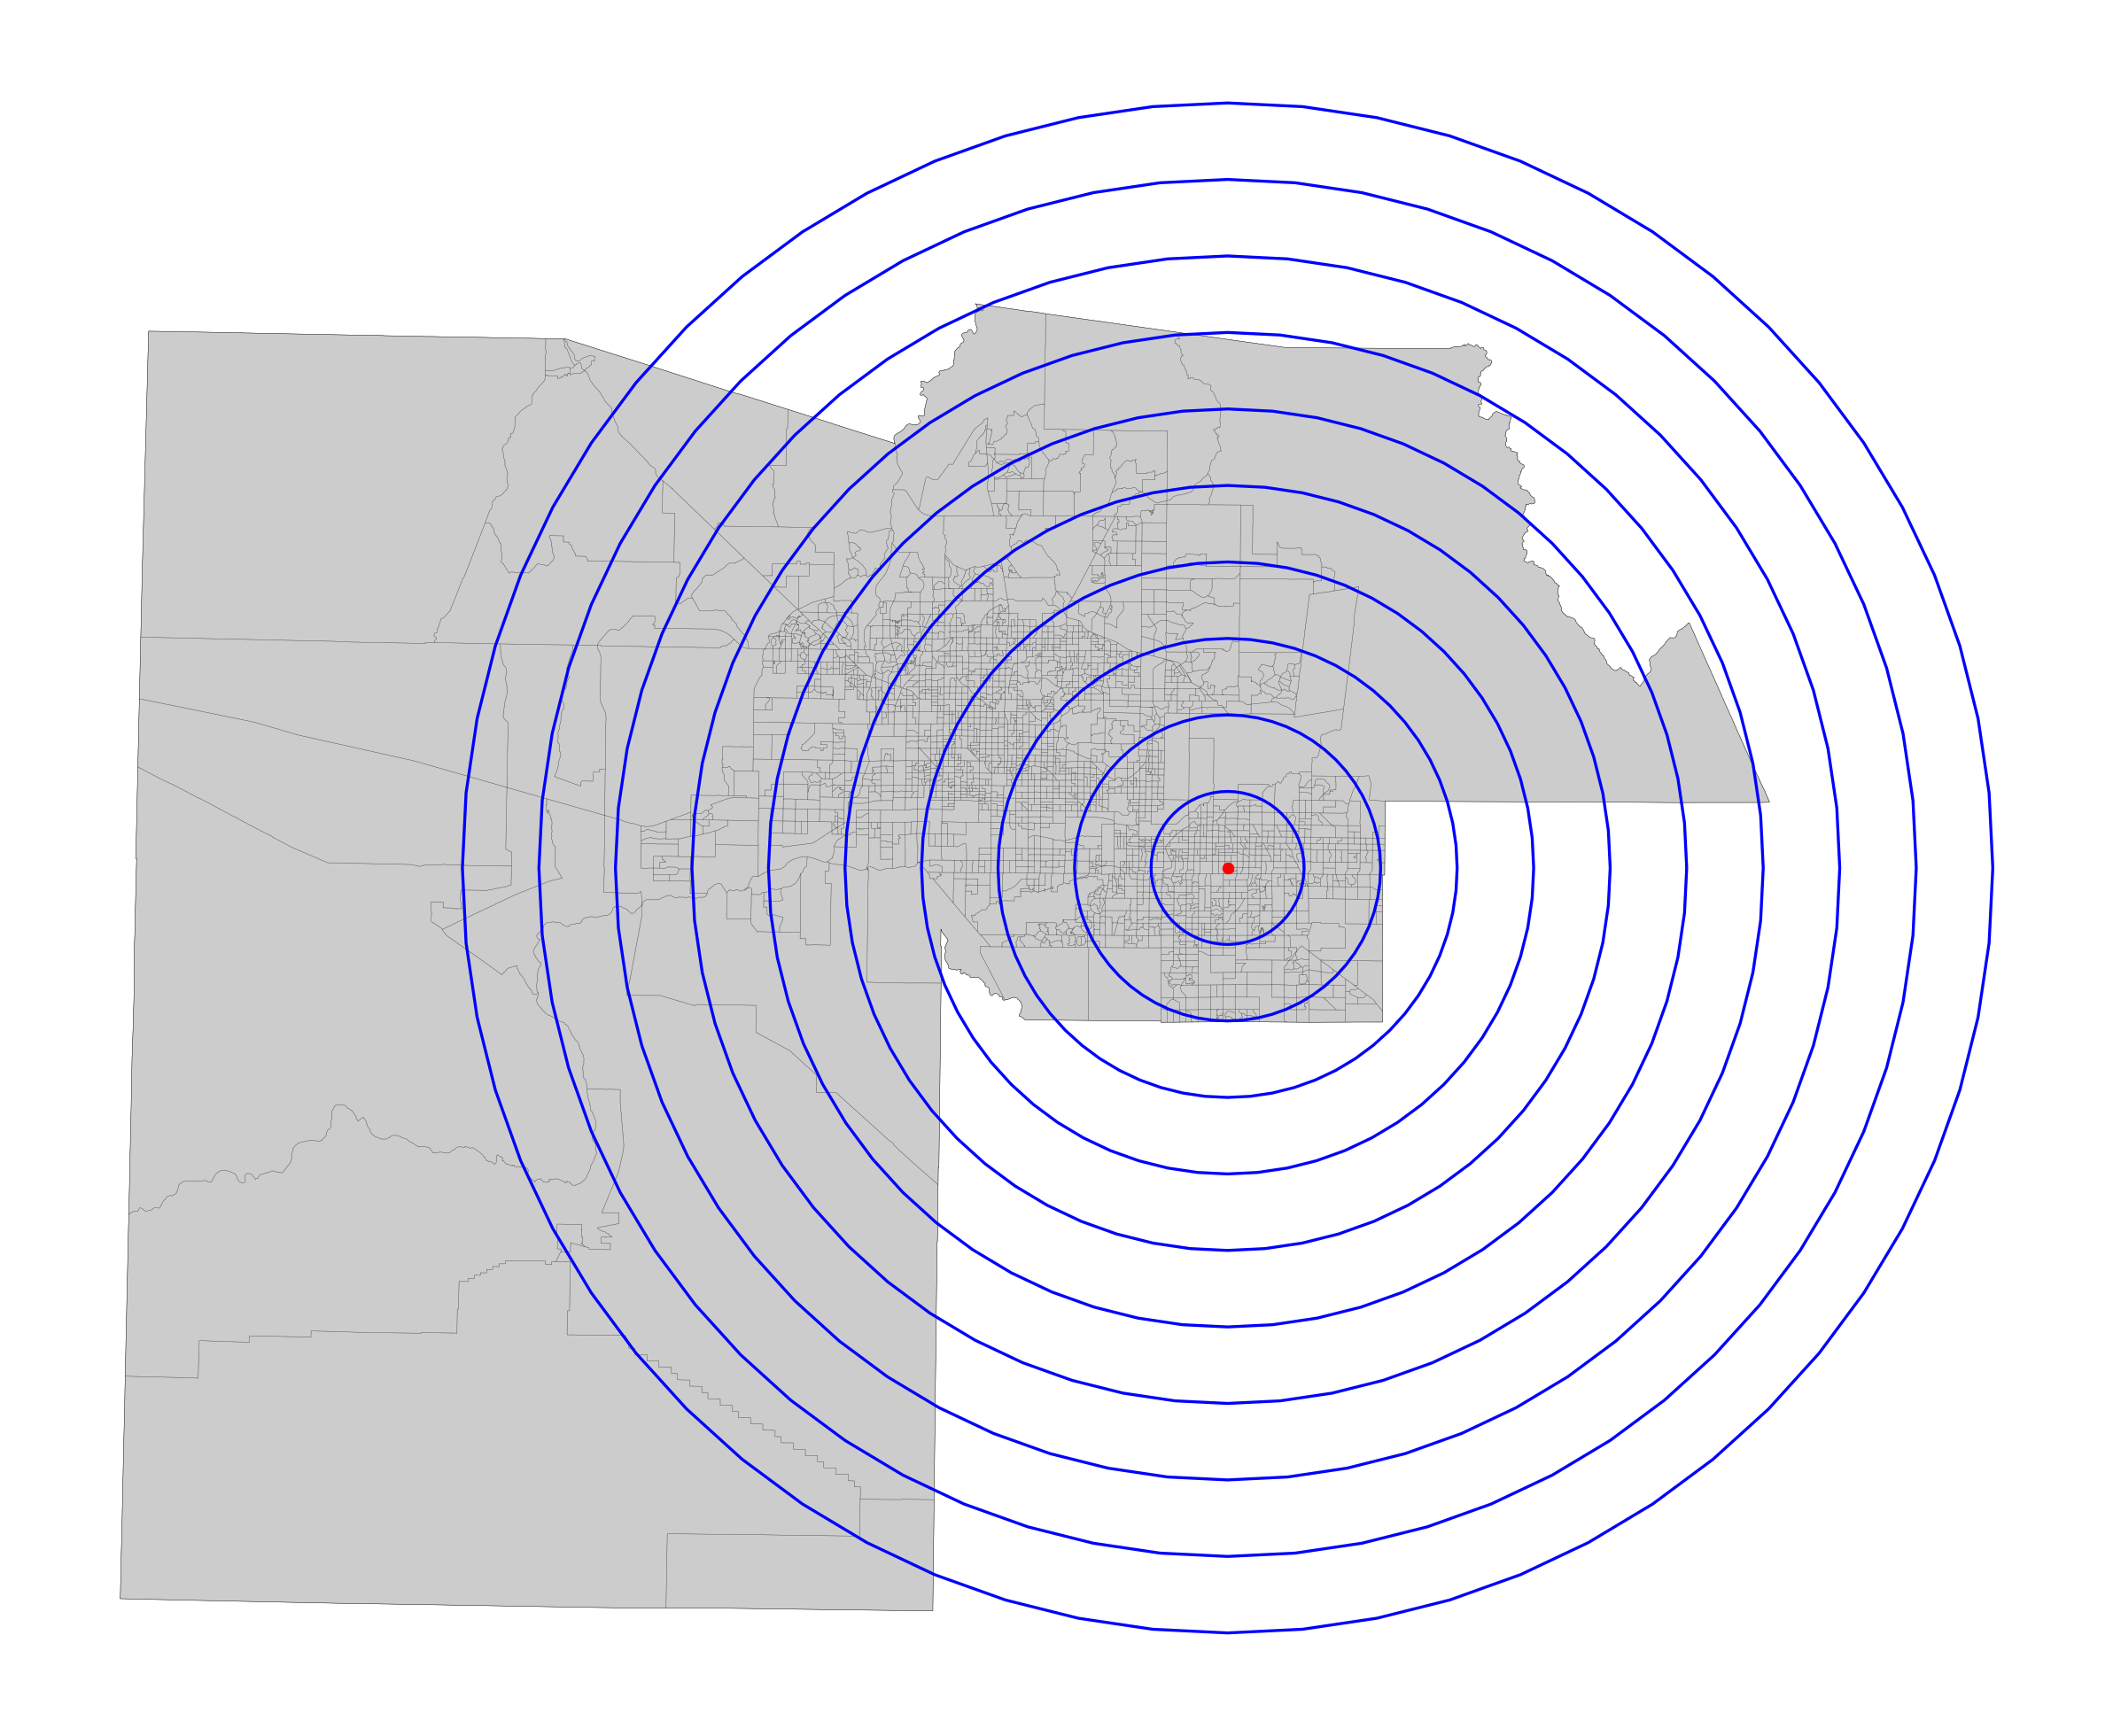

In [106]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame, GeoSeries

# Assuming 'census_block_groups' and 'census_counties' are your initial GeoDataFrames loaded with data
# and are in EPSG:4326

# Step 1: Dissolve all census block groups into one
dissolved = census_block_groups.dissolve()  # This combines all polygons into one

# Before finding the centroid, project the dissolved geometry to a projected CRS
dissolved_projected = dissolved.to_crs(epsg=26912)
census_block_groups = census_block_groups.to_crs(epsg=26912)

# Use the specified longitude and latitude for the centroid
longitude, latitude = -111.80141612966149, 33.385925714693485
centroid = Point(longitude, latitude)

# Create a GeoSeries with the centroid and project it to the same CRS
CBG_series = GeoSeries([centroid], crs="EPSG:4326")
CBG_series = CBG_series.to_crs(epsg=26912)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
# It's important to plot the projected dissolved geometry
dissolved_projected.plot(linewidth=0.1, ax=ax, edgecolor='black', color='none')
census_block_groups.plot(linewidth=0.1, ax=ax, edgecolor='black', color='grey', alpha=0.4)

# Since the centroid is already in the projected CRS, we can plot it directly
CBG_series.plot(marker='o', color='red', markersize=5, ax=ax)

# Create circles with different radii
circle_list_km = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
circles = GeoSeries([CBG_series.geometry[0].buffer(km * 1000) for km in circle_list_km], crs="EPSG:26912")
circles.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.8)

ax.axis('off')
plt.show()



In [148]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'gpd_df' is your GeoDataFrame and has columns from day 1 to day 30
columns_to_analyze = [f'day {day}' for day in range(1, 31)]

# Exclude the row with GEOID '040134223021'
gpd_df_filtered = gpd_df[gpd_df['GEOID'] != '040134223021']

# Calculate mean, median, and mode for each row in the filtered DataFrame
gpd_df_filtered['mean visitor'] = gpd_df_filtered[columns_to_analyze].mean(axis=1)
gpd_df_filtered['median visitor'] = gpd_df_filtered[columns_to_analyze].median(axis=1)

gpd_df_filtered.head()


/Users/alexandernez/Desktop/Github/Epymorph_vignettes/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alexandernez/Desktop/Github/Epymorph_vignettes/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      04      013  421702        3  040134217023  Block Group 3  G5030   
1      04      013  040531        2  040130405312  Block Group 2  G5030   
2      04      013  092312        1  040130923121  Block Group 1  G5030   
3      04      013  092721        1  040130927211  Block Group 1  G5030   
4      04      013  093104        1  040130931041  Block Group 1  G5030   

  FUNCSTAT    ALAND  AWATER  ... day 245 day 246 day 247 day 248  day 249  \
0        S   310375       0  ...       0       0       0       2        0   
1        S   616061       0  ...       0       0       0       0        0   
2        S   295623       0  ...       0       0       0       0        0   
3        S  1108648       0  ...       0       0       0       0        1   
4        S   168697       0  ...       0       0       0       0        0   

   day 250  day 251  day 252  mean visitor  median visitor  
0        1        0        1           0.0             0.0  
1        0        0        0           0.0             0.0  
2        0        0        0           0.0             0.0  
3        0        0        0           0.0             0.0  
4        0        0        1           0.0             0.0  

[5 rows x 268 columns]

In [169]:
gpd_df

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0         04      013  421702        3  040134217023  Block Group 3  G5030   
1         04      013  040531        2  040130405312  Block Group 2  G5030   
2         04      013  092312        1  040130923121  Block Group 1  G5030   
3         04      013  092721        1  040130927211  Block Group 1  G5030   
4         04      013  093104        1  040130931041  Block Group 1  G5030   
...      ...      ...     ...      ...           ...            ...    ...   
2489      04      013  811900        2  040138119002  Block Group 2  G5030   
2490      04      013  812000        1  040138120001  Block Group 1  G5030   
2491      04      013  812000        2  040138120002  Block Group 2  G5030   
2492      04      013  523002        3  040135230023  Block Group 3  G5030   
2493      04      013  523102        3  040135231023  Block Group 3  G5030   

     FUNCSTAT    ALAND  AWATER  ... day 244 day 245 day 246 day 247  day 248  \
0           S   310375       0  ...       0       0       0       0        2   
1           S   616061       0  ...       0       0       0       0        0   
2           S   295623       0  ...       0       0       0       0        0   
3           S  1108648       0  ...       0       0       0       0        0   
4           S   168697       0  ...       0       0       0       0        0   
...       ...      ...     ...  ...     ...     ...     ...     ...      ...   
2489        S   771839       0  ...       0       0       0       0        0   
2490        S  1279036       0  ...       0       0       0       0        0   
2491        S  1360898       0  ...       0       0       0       0        0   
2492        S   666349       0  ...       0       0       0       0        0   
2493        S   953890       0  ...       0       0       0       0        0   

      day 249  day 250  day 251  day 252   distance  
0           0        1        0        1  26.551153  
1           0        0        0        0  24.990364  
2           0        0        0        0  24.617582  
3           1        0        0        0  28.942065  
4           0        0        0        1  30.552551  
...       ...      ...      ...      ...        ...  
2489        0        0        0        0   9.968590  
2490        0        0        0        0  10.286808  
2491        0        0        0        0   6.449305  
2492        0        0        0        0   8.101370  
2493        0        0        0        0  11.085171  

[2494 rows x 267 columns]

In [170]:
def haversine(centroid_1_lon: float, centroid_1_lat: float,
              centroid_2_lon: float, centroid_2_lat: float) -> np.double:
    R = 3959.87433
    dLat = np.radians(centroid_1_lat - centroid_2_lat)
    dLon = np.radians(centroid_1_lon - centroid_2_lon)
    lat1 = np.radians(centroid_1_lat)
    lat2 = np.radians(centroid_2_lat)

    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [175]:


# Find the index of the row with the specified geoid
index = sdh_df[sdh_df['geoid'] == '040134223021'].index[0]
index


1820

In [186]:
num_labels

2505

In [187]:
num_labels = len(sdh_df['label'])
distances = np.zeros((num_labels, num_labels))
phi_values = np.zeros((num_labels, num_labels))
phi_0 = 0.10

# Calculate distances
for i in range(num_labels):
    for j in range(num_labels):
        if i != j:
            distances[i, j] = haversine(sdh_df['centroid'][i][0], sdh_df['centroid'][i][1],
                                       sdh_df['centroid'][j][0], sdh_df['centroid'][j][1])




centroid         geoid         label  \
0     [-111.77075643330394, 33.76924660709943]  040130101011  040130101011   
1      [-111.72000671148204, 33.7410933260103]  040130101012  040130101012   
2     [-111.66697569766907, 33.72404113568911]  040130101013  040130101013   
3     [-111.49136471795472, 33.71546544071483]  040130101021  040130101021   
4      [-111.8505100649063, 33.82609833466325]  040130101022  040130101022   
...                                        ...           ...           ...   
2489  [-111.87417248956888, 33.51676571547603]  040139413001  040139413001   
2490  [-111.75549278099597, 33.52975077659579]  040139413002  040139413002   
2491   [-111.88183665206864, 33.4507490858319]  040139413003  040139413003   
2492  [-111.84018577905717, 33.49859253583006]  040139413004  040139413004   
2493  [-111.61909767565444, 33.33555256790642]  040139806001  040139806001   

      population                                   school_commuters  \
0              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...          ...                                                ...   
2489           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2490           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2491           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2492           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2493           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

       distance    phi 10    phi 20    phi 30    phi 40    phi 50  
0     26.551153  0.070291  0.265124  0.412698  0.514902  0.588003  
1     24.990364  0.082164  0.286643  0.434738  0.535390  0.606648  
2     24.617582  0.085285  0.292036  0.440174  0.540403  0.611187  
3     28.942065  0.055343  0.235251  0.381084  0.485027  0.560547  
4     30.552551  0.047111  0.217050  0.361166  0.465886  0.542780  
...         ...       ...       ...       ...       ...       ...  
2489   9.968590  0.369037  0.607484  0.717282  0.779413  0.819245  
2490  10.286808  0.357478  0.597895  0.709714  0.773237  0.814048  
2491   6.449305  0.524699  0.724361  0.806560  0.851094  0.878986  
2492   8.101370  0.444797  0.666931  0.763345  0.816659  0.850418  
2493  11.085171  0.330048  0.574498  0.691076  0.757957  0.801153  

[2494 rows x 11 columns]

In [323]:
phi_10 = 1 / np.exp(distances * (1/10))
phi_20 = 1 / np.exp(distances * (1/20))
phi_30 = 1 / np.exp(distances * (1/30))
phi_40 = 1 / np.exp(distances * (1/40))
phi_50 = 1 / np.exp(distances * (1/50))

# Save phi and distances as CSV
phi_10_df = pd.DataFrame(phi_10)
phi_20_df = pd.DataFrame(phi_20)
phi_30_df = pd.DataFrame(phi_30)
phi_40_df = pd.DataFrame(phi_40)
phi_50_df = pd.DataFrame(phi_50)
dist_df = pd.DataFrame(distances)
p_cbg = 1820
cgb_d = dist_df.iloc[:, p_cbg]
cgb_10 = phi_10_df.iloc[:, p_cbg]
cgb_20 = phi_20_df.iloc[:, p_cbg]
cgb_30 = phi_30_df.iloc[:, p_cbg]
cgb_40 = phi_40_df.iloc[:, p_cbg]
cgb_50 = phi_50_df.iloc[:, p_cbg]

cgb = pd.concat([cgb_d, cgb_10, cgb_20, cgb_30, cgb_40, cgb_50], axis=1)
cgb.columns = ["distance", "phi 10", "phi 20", "phi 30", "phi 40", "phi 50"]

sim_data_df = [sdh_df,cgb] 
dist_df = pd.concat(sim_data_df, axis =1)

gpd_df = gpd.GeoDataFrame(dist_df)
gpd_df


centroid         geoid         label  \
0     [-111.77075643330394, 33.76924660709943]  040130101011  040130101011   
1      [-111.72000671148204, 33.7410933260103]  040130101012  040130101012   
2     [-111.66697569766907, 33.72404113568911]  040130101013  040130101013   
3     [-111.49136471795472, 33.71546544071483]  040130101021  040130101021   
4      [-111.8505100649063, 33.82609833466325]  040130101022  040130101022   
...                                        ...           ...           ...   
2489  [-111.87417248956888, 33.51676571547603]  040139413001  040139413001   
2490  [-111.75549278099597, 33.52975077659579]  040139413002  040139413002   
2491   [-111.88183665206864, 33.4507490858319]  040139413003  040139413003   
2492  [-111.84018577905717, 33.49859253583006]  040139413004  040139413004   
2493  [-111.61909767565444, 33.33555256790642]  040139806001  040139806001   

      population                                   school_commuters  \
0              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...          ...                                                ...   
2489           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2490           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2491           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2492           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2493           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

       distance    phi 10    phi 20    phi 30    phi 40    phi 50  
0     26.551153  0.070291  0.265124  0.412698  0.514902  0.588003  
1     24.990364  0.082164  0.286643  0.434738  0.535390  0.606648  
2     24.617582  0.085285  0.292036  0.440174  0.540403  0.611187  
3     28.942065  0.055343  0.235251  0.381084  0.485027  0.560547  
4     30.552551  0.047111  0.217050  0.361166  0.465886  0.542780  
...         ...       ...       ...       ...       ...       ...  
2489   9.968590  0.369037  0.607484  0.717282  0.779413  0.819245  
2490  10.286808  0.357478  0.597895  0.709714  0.773237  0.814048  
2491   6.449305  0.524699  0.724361  0.806560  0.851094  0.878986  
2492   8.101370  0.444797  0.666931  0.763345  0.816659  0.850418  
2493  11.085171  0.330048  0.574498  0.691076  0.757957  0.801153  

[2494 rows x 11 columns]

In [324]:

# Drop the specified columns from gpd_df
columns_to_drop = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']
sim_df = sim_df.drop(columns=columns_to_drop)
sim_df


label  day 1  day 2  day 3  day 4  day 5  day 6  day 7  day 8  \
0     040134217023      0      0      0      0      0      0      0      0   
1     040130405312      0      0      0      0      0      0      0      0   
2     040130923121      0      0      0      0      0      0      0      0   
3     040130927211      0      0      0      0      0      0      0      0   
4     040130931041      0      0      0      0      1      0      0      0   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
2489  040138119002      0      0      0      0      0      0      0      0   
2490  040138120001      0      0      0      0      1      0      0      0   
2491  040138120002      0      0      0      0      0      0      0      0   
2492  040135230023      0      0      0      0      0      0      0      0   
2493  040135231023      0      0      0      0      0      0      0      0   

      day 9  ...  day 243  day 244  day 245  day 246  day 247  day 248  \
0         0  ...        0        0        0        0        0        0   
1         0  ...        0        0        0        0        0        0   
2         0  ...        0        0        0        0        0        0   
3         0  ...        0        0        0        0        0        0   
4         0  ...        0        0        0        0        0        0   
...     ...  ...      ...      ...      ...      ...      ...      ...   
2489      0  ...        0        0        0        0        0        0   
2490      0  ...        0        0        0        0        0        0   
2491      0  ...        0        0        0        0        0        0   
2492      0  ...        0        0        0        0        0        0   
2493      0  ...        0        0        0        0        0        0   

      day 249  day 250  day 251  day 252  
0           0        0        0        0  
1           0        0        0        0  
2           0        0        0        0  
3           0        0        0        0  
4           0        0        0        0  
...       ...      ...      ...      ...  
2489        0        0        0        0  
2490        0        0        0        0  
2491        0        0        0        0  
2492        0        0        0        0  
2493        0        0        0        0  

[2494 rows x 253 columns]

In [325]:
gpd_df = gpd_df.merge(sim_df, left_on='geoid', right_on='label')
gpd_df

centroid         geoid       label_x  \
0     [-111.77075643330394, 33.76924660709943]  040130101011  040130101011   
1      [-111.72000671148204, 33.7410933260103]  040130101012  040130101012   
2     [-111.66697569766907, 33.72404113568911]  040130101013  040130101013   
3     [-111.49136471795472, 33.71546544071483]  040130101021  040130101021   
4      [-111.8505100649063, 33.82609833466325]  040130101022  040130101022   
...                                        ...           ...           ...   
2489  [-111.87417248956888, 33.51676571547603]  040139413001  040139413001   
2490  [-111.75549278099597, 33.52975077659579]  040139413002  040139413002   
2491   [-111.88183665206864, 33.4507490858319]  040139413003  040139413003   
2492  [-111.84018577905717, 33.49859253583006]  040139413004  040139413004   
2493  [-111.61909767565444, 33.33555256790642]  040139806001  040139806001   

      population                                   school_commuters  \
0              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...          ...                                                ...   
2489           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2490           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2491           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2492           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2493           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

       distance    phi 10    phi 20    phi 30    phi 40  ...  day 243 day 244  \
0     26.551153  0.070291  0.265124  0.412698  0.514902  ...        0       0   
1     24.990364  0.082164  0.286643  0.434738  0.535390  ...        0       0   
2     24.617582  0.085285  0.292036  0.440174  0.540403  ...        0       0   
3     28.942065  0.055343  0.235251  0.381084  0.485027  ...        0       2   
4     30.552551  0.047111  0.217050  0.361166  0.465886  ...        0       0   
...         ...       ...       ...       ...       ...  ...      ...     ...   
2489   9.968590  0.369037  0.607484  0.717282  0.779413  ...        0       0   
2490  10.286808  0.357478  0.597895  0.709714  0.773237  ...        0       0   
2491   6.449305  0.524699  0.724361  0.806560  0.851094  ...        0       0   
2492   8.101370  0.444797  0.666931  0.763345  0.816659  ...        0       0   
2493  11.085171  0.330048  0.574498  0.691076  0.757957  ...        0       0   

      day 245  day 246  day 247  day 248  day 249  day 250  day 251  day 252  
0           0        0        0        0        0        0        0        0  
1           0        0        0        0        0        0        0        0  
2           0        0        0        0        0        0        0        0  
3           0        0        0        0        0        0        0        0  
4           0        0        0        0        0        0        0        0  
...       ...      ...      ...      ...      ...      ...      ...      ...  
2489        0        0        0        0        0        0        0        0  
2490        0        0        0        0        0        0        0        0  
2491        0        0        0        0        0        0        0        0  
2492        0        0        0        0        0        0        0        0  
2493        0        0        0        0        0        0        0        0  

[2494 rows x 264 columns]

In [326]:
gpd_df = gpd_df.merge(census_block_groups, left_on='geoid', right_on='GEOID')


/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_5156/4073078449.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_movers = gpd_df.groupby('distance_bin')['total_movers'].sum().reindex(circle_list_km, fill_value=0)


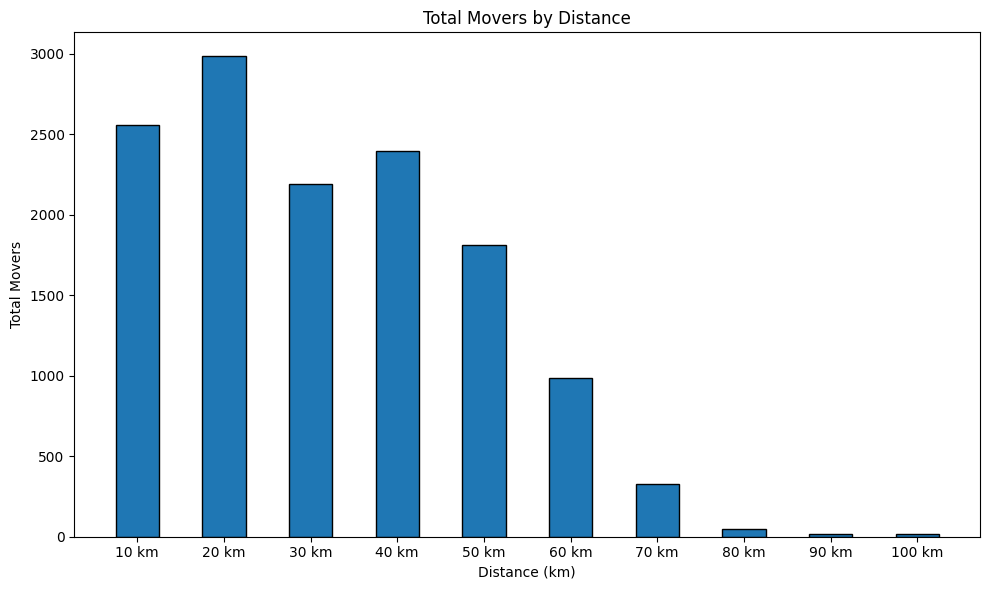

In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the distance bins in miles (since 1 km = 0.621371 miles)
circle_list_km = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
distance_bins = [0] + [km * 0.621371 for km in circle_list_km]  # Include zero to start the bins correctly

# Assuming the columns are named 'day 1', 'day 2', ..., 'day 252'
days = [f'day {i}' for i in range(1, 253)]

# Calculate the total movers for each node for each day
gpd_df['total_movers'] = gpd_df[days].sum(axis=1)

# Create a new column for the distance bins
gpd_df['distance_bin'] = pd.cut(gpd_df['distance'], bins=distance_bins, labels=circle_list_km)

# Adjust the total movers to be representative of the population
total_population = gpd_df['population'].max()
gpd_df['adjusted_movers'] = gpd_df['total_movers'] / gpd_df['total_movers'].sum() * total_population

# Sum the total movers for each distance bin
distance_movers = gpd_df.groupby('distance_bin')['total_movers'].sum().reindex(circle_list_km, fill_value=0)


# Create the histogram
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(distance_movers.index.astype(float), distance_movers.values, width=5, edgecolor='black')

ax.set_xlabel('Distance (km)')
ax.set_ylabel('Total Movers')
ax.set_title('Total Movers by Distance')
ax.set_xticks(circle_list_km)
ax.set_xticklabels([f'{int(km)} km' for km in circle_list_km])

plt.tight_layout()
plt.show()



In [288]:
 gpd_df['total_movers']

0        6
1        0
2        3
3        0
4        0
        ..
2489     7
2490     6
2491    12
2492    11
2493    17
Name: total_movers, Length: 2494, dtype: int64

AttributeError: Line2D.set() got an unexpected keyword argument 'edgecolor'

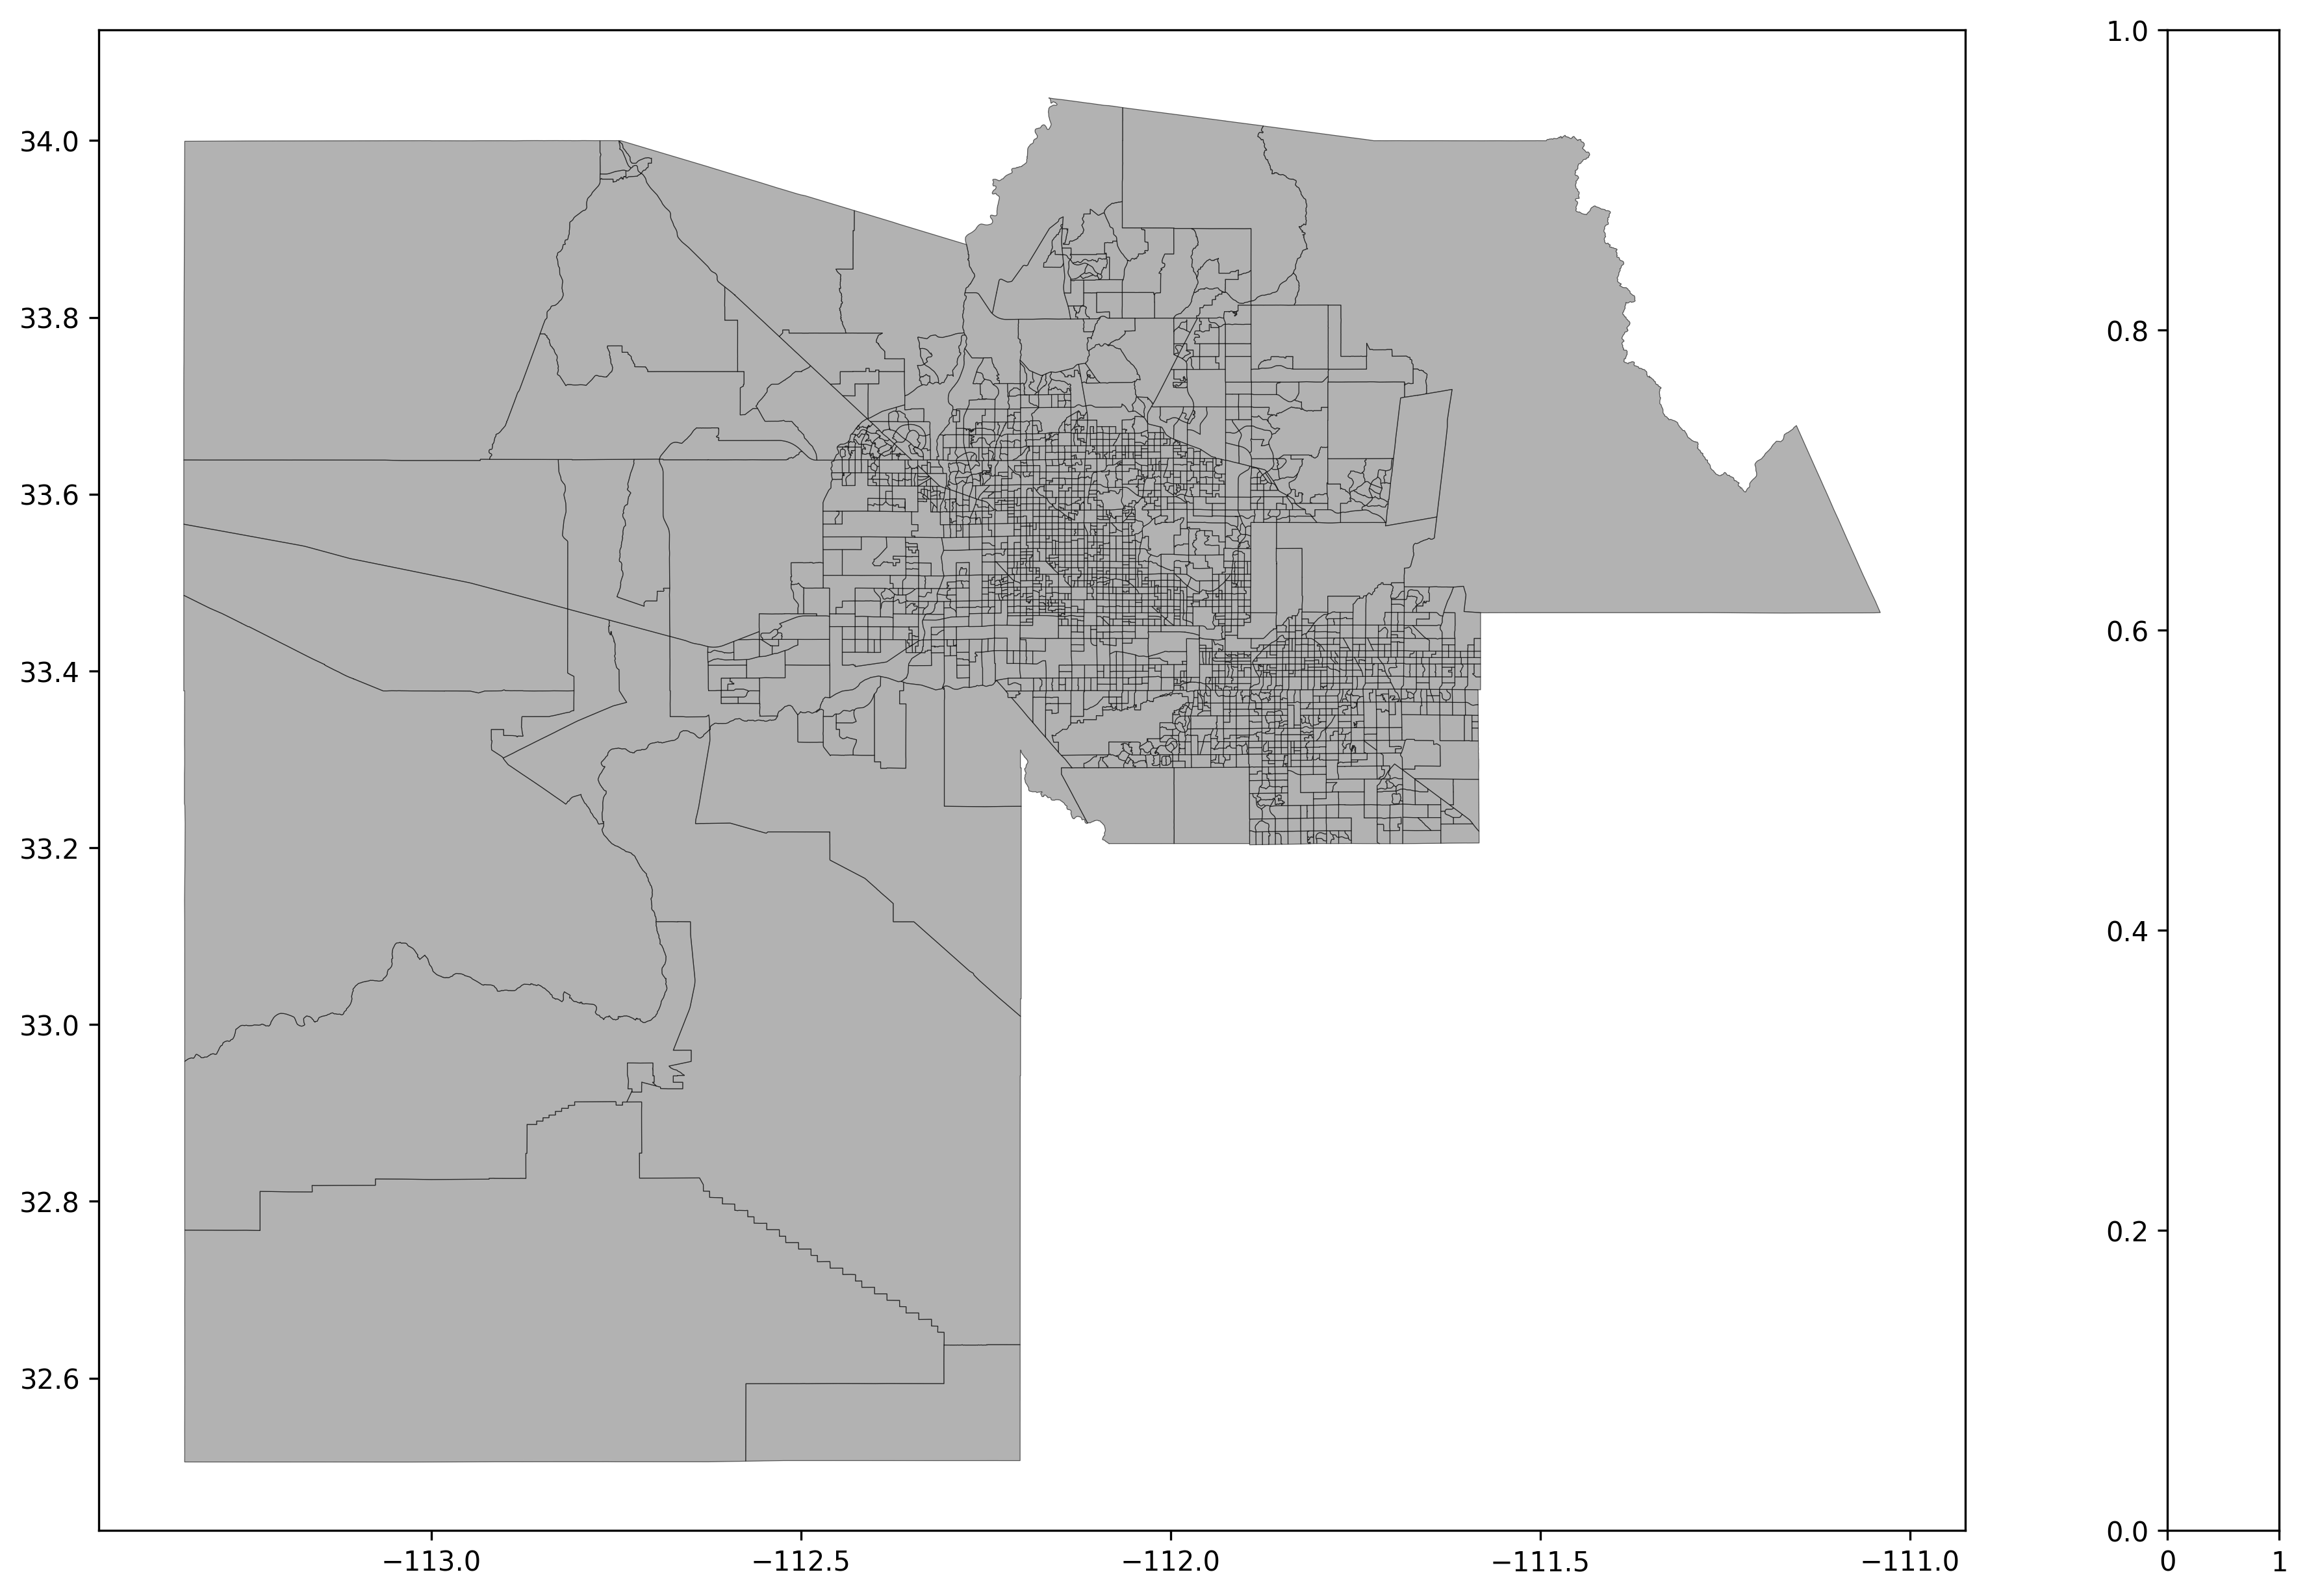

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Plot the distances
fig, ax1 = plt.subplots(1, figsize=(20, 10), dpi=300)

census_block_groups.plot(ax=ax1, linewidth=0.3, edgecolor='black', color='grey', alpha=0.6)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
gpd_df.plot(column='distance', ax=ax1, legend=True, vmin=gpd_df['distance'].min(), vmax=gpd_df['distance'].max(), cmap="viridis", edgecolor='black', linewidth=0.3, cax=cax)
ax1.set_title('Distance from GEOID 040134223021')
ax1.axis('off')

plt.tight_layout()
plt.show()


In [166]:
sdh_df['centroid']

centroid         geoid         label  \
0     [-111.77075643330394, 33.76924660709943]  040130101011  040130101011   
1      [-111.72000671148204, 33.7410933260103]  040130101012  040130101012   
2     [-111.66697569766907, 33.72404113568911]  040130101013  040130101013   
3     [-111.49136471795472, 33.71546544071483]  040130101021  040130101021   
4      [-111.8505100649063, 33.82609833466325]  040130101022  040130101022   
...                                        ...           ...           ...   
2489  [-111.87417248956888, 33.51676571547603]  040139413001  040139413001   
2490  [-111.75549278099597, 33.52975077659579]  040139413002  040139413002   
2491   [-111.88183665206864, 33.4507490858319]  040139413003  040139413003   
2492  [-111.84018577905717, 33.49859253583006]  040139413004  040139413004   
2493  [-111.61909767565444, 33.33555256790642]  040139806001  040139806001   

      population                                   school_commuters  
0              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4              0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...          ...                                                ...  
2489           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2490           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2491           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2492           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2493           0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[2494 rows x 5 columns]

/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_5156/557982712.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpd_df_filtered['mean visitor'] = gpd_df_filtered[columns_to_analyze].mean(axis=1)
/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_5156/557982712.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpd_df_filtered['median visitor'] = gpd_df_filtered[columns_to_analyze].median(axis=1)


AttributeError: Line2D.set() got an unexpected keyword argument 'vmin'

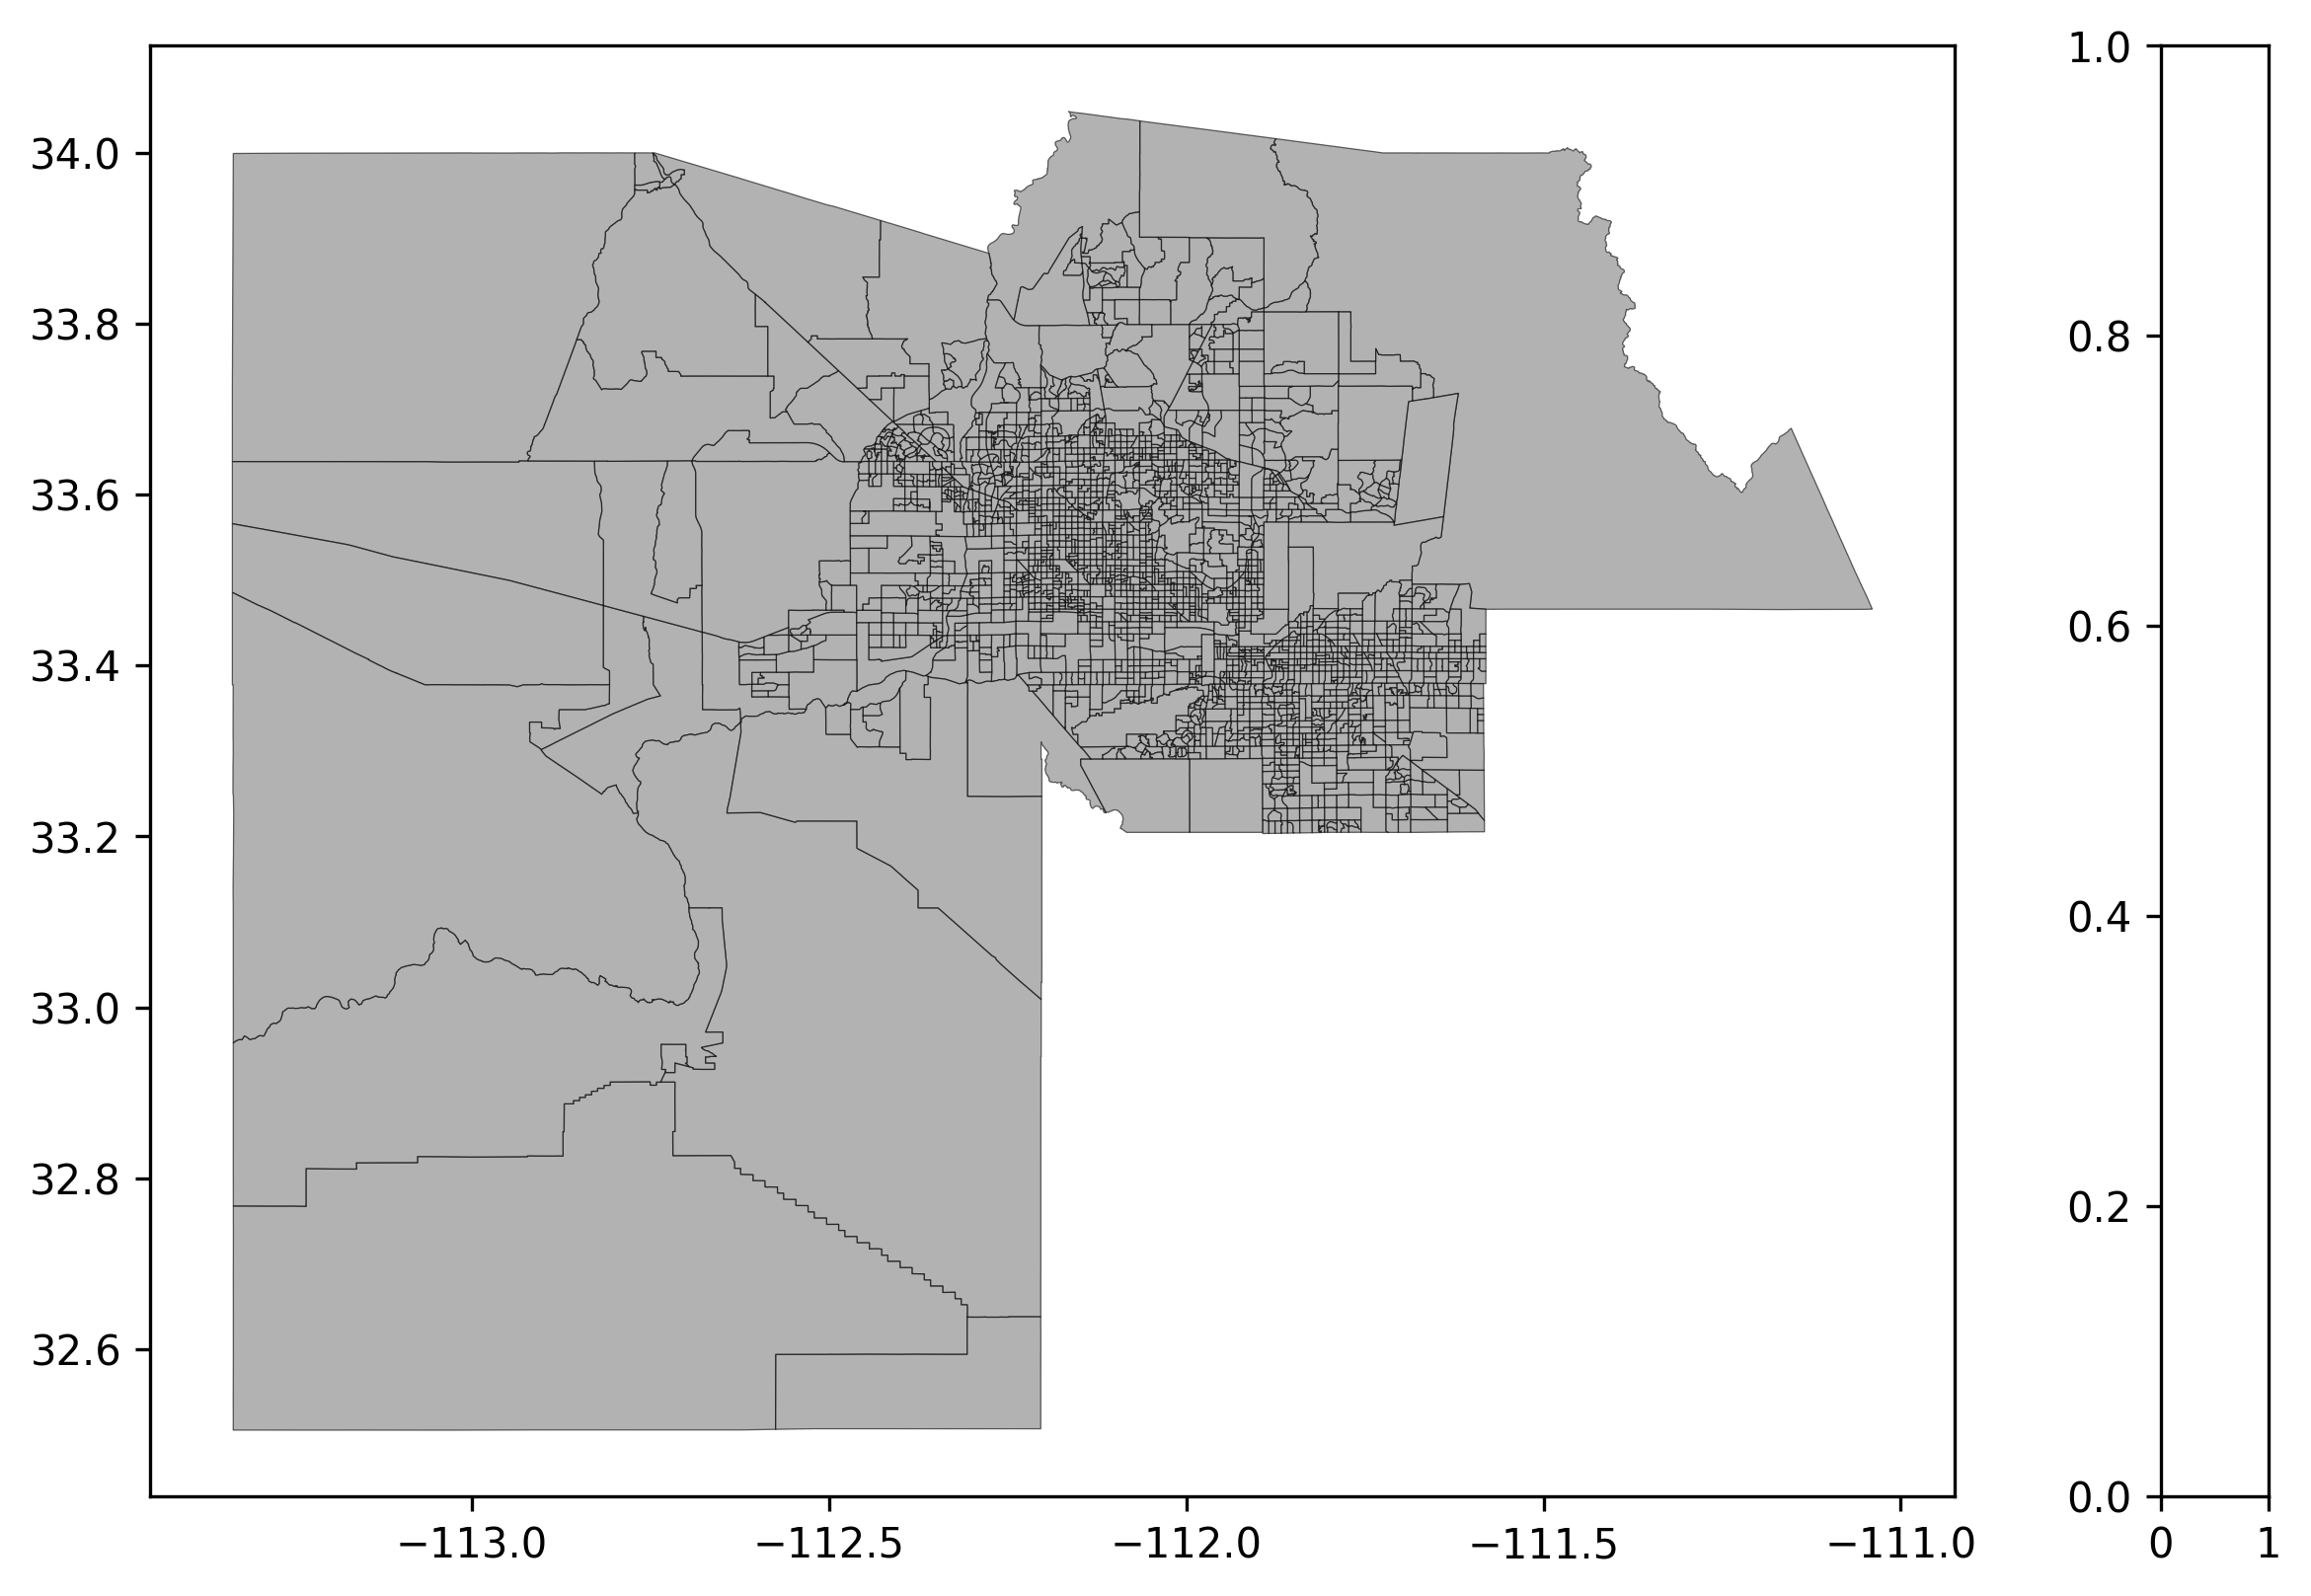

In [254]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming 'gpd_df' is your GeoDataFrame and has columns from day 1 to day 30
columns_to_analyze = [f'day {day}' for day in range(1, 31)]

# Exclude the row with GEOID '040134223021'
gpd_df_filtered = gpd_df[gpd_df['GEOID'] != '040134223021']

# Calculate mean, median, and mode for each row in the filtered DataFrame
gpd_df_filtered['mean visitor'] = gpd_df_filtered[columns_to_analyze].mean(axis=1)
gpd_df_filtered['median visitor'] = gpd_df_filtered[columns_to_analyze].median(axis=1)

# Separate the row to be highlighted
highlighted_gdf = gpd_df[gpd_df['GEOID'] == '040134223021']

# Set vmin and vmax for both plots
vmin = gpd_df_filtered[['mean visitor', 'median visitor']].min().min()
vmax = gpd_df_filtered[['mean visitor', 'median visitor']].max().max()

# Plot mean visitor
fig, ax1 = plt.subplots(figsize=(10, 10), dpi=300)
census_block_groups.plot(ax=ax1, linewidth=0.3, edgecolor='black', color='grey', alpha=0.6)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
gpd_df_filtered.plot(column='mean visitor', ax=ax1, legend=True, vmin=vmin, vmax=vmax, cmap="Blues_r", edgecolor='black', linewidth=0.3, cax=cax)
highlighted_gdf.plot(ax=ax1, edgecolor='red', linewidth=1, facecolor='none')  
ax1.set_title('Mean Visitor')
ax1.axis('off')
plt.show()


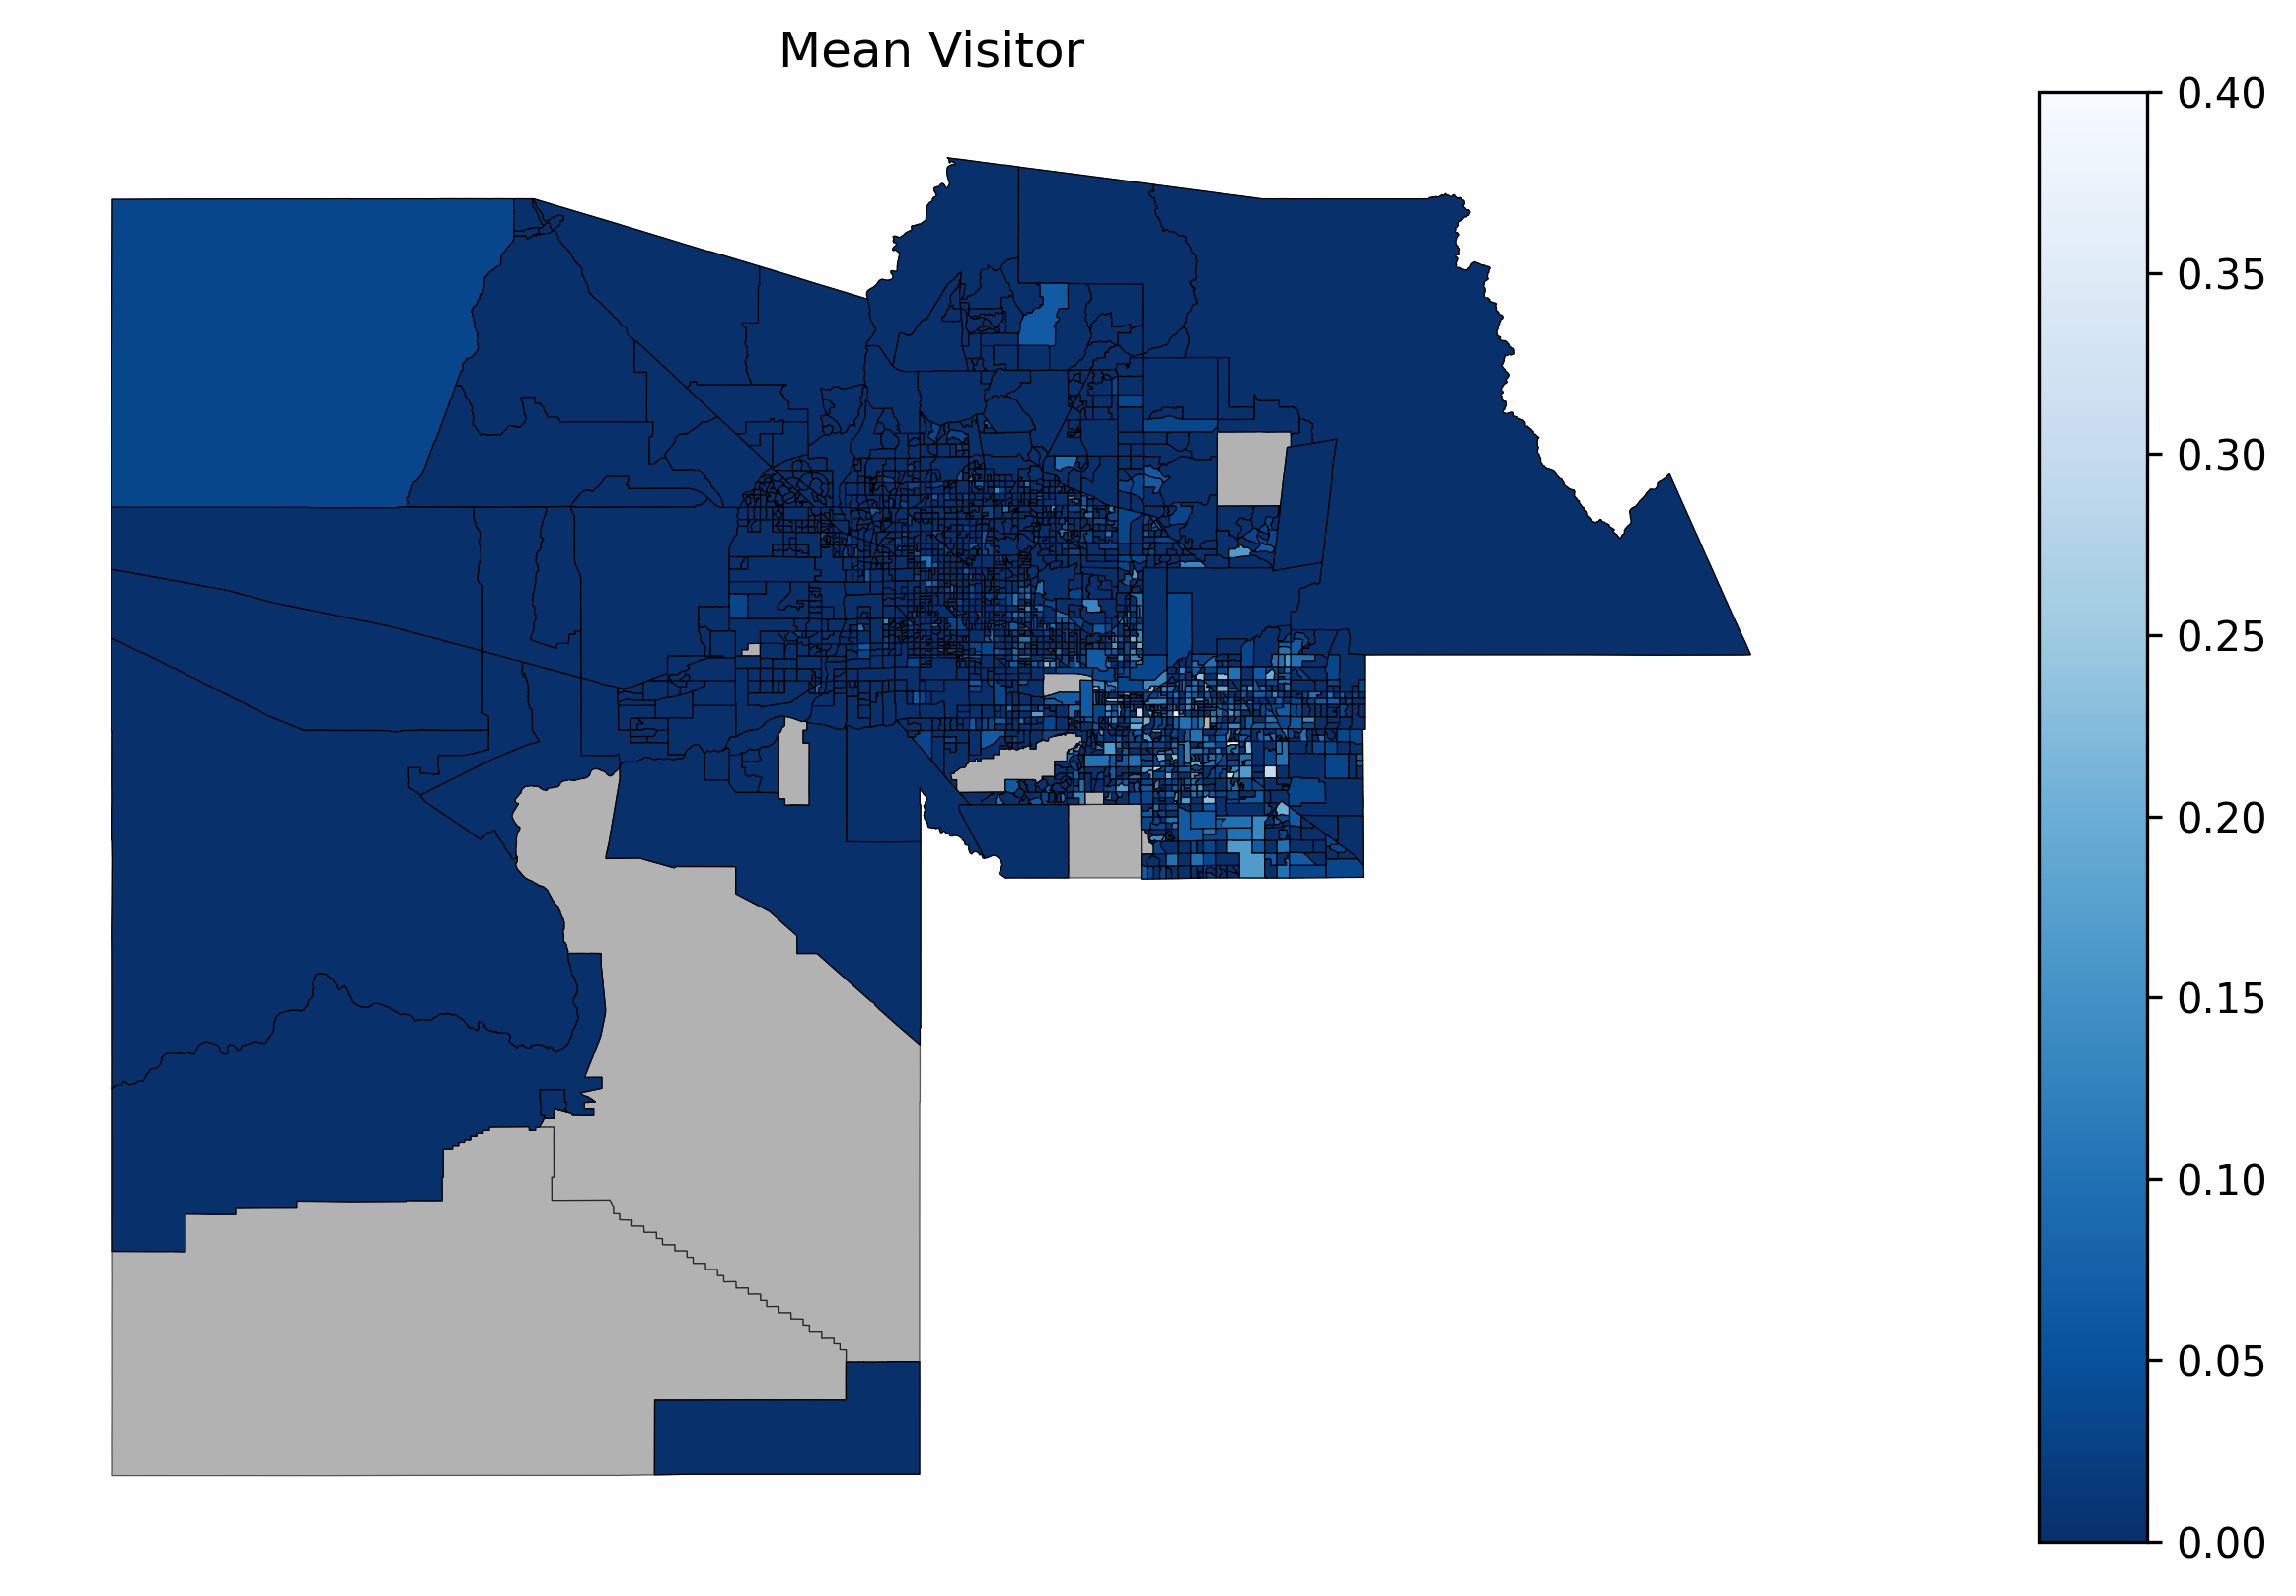

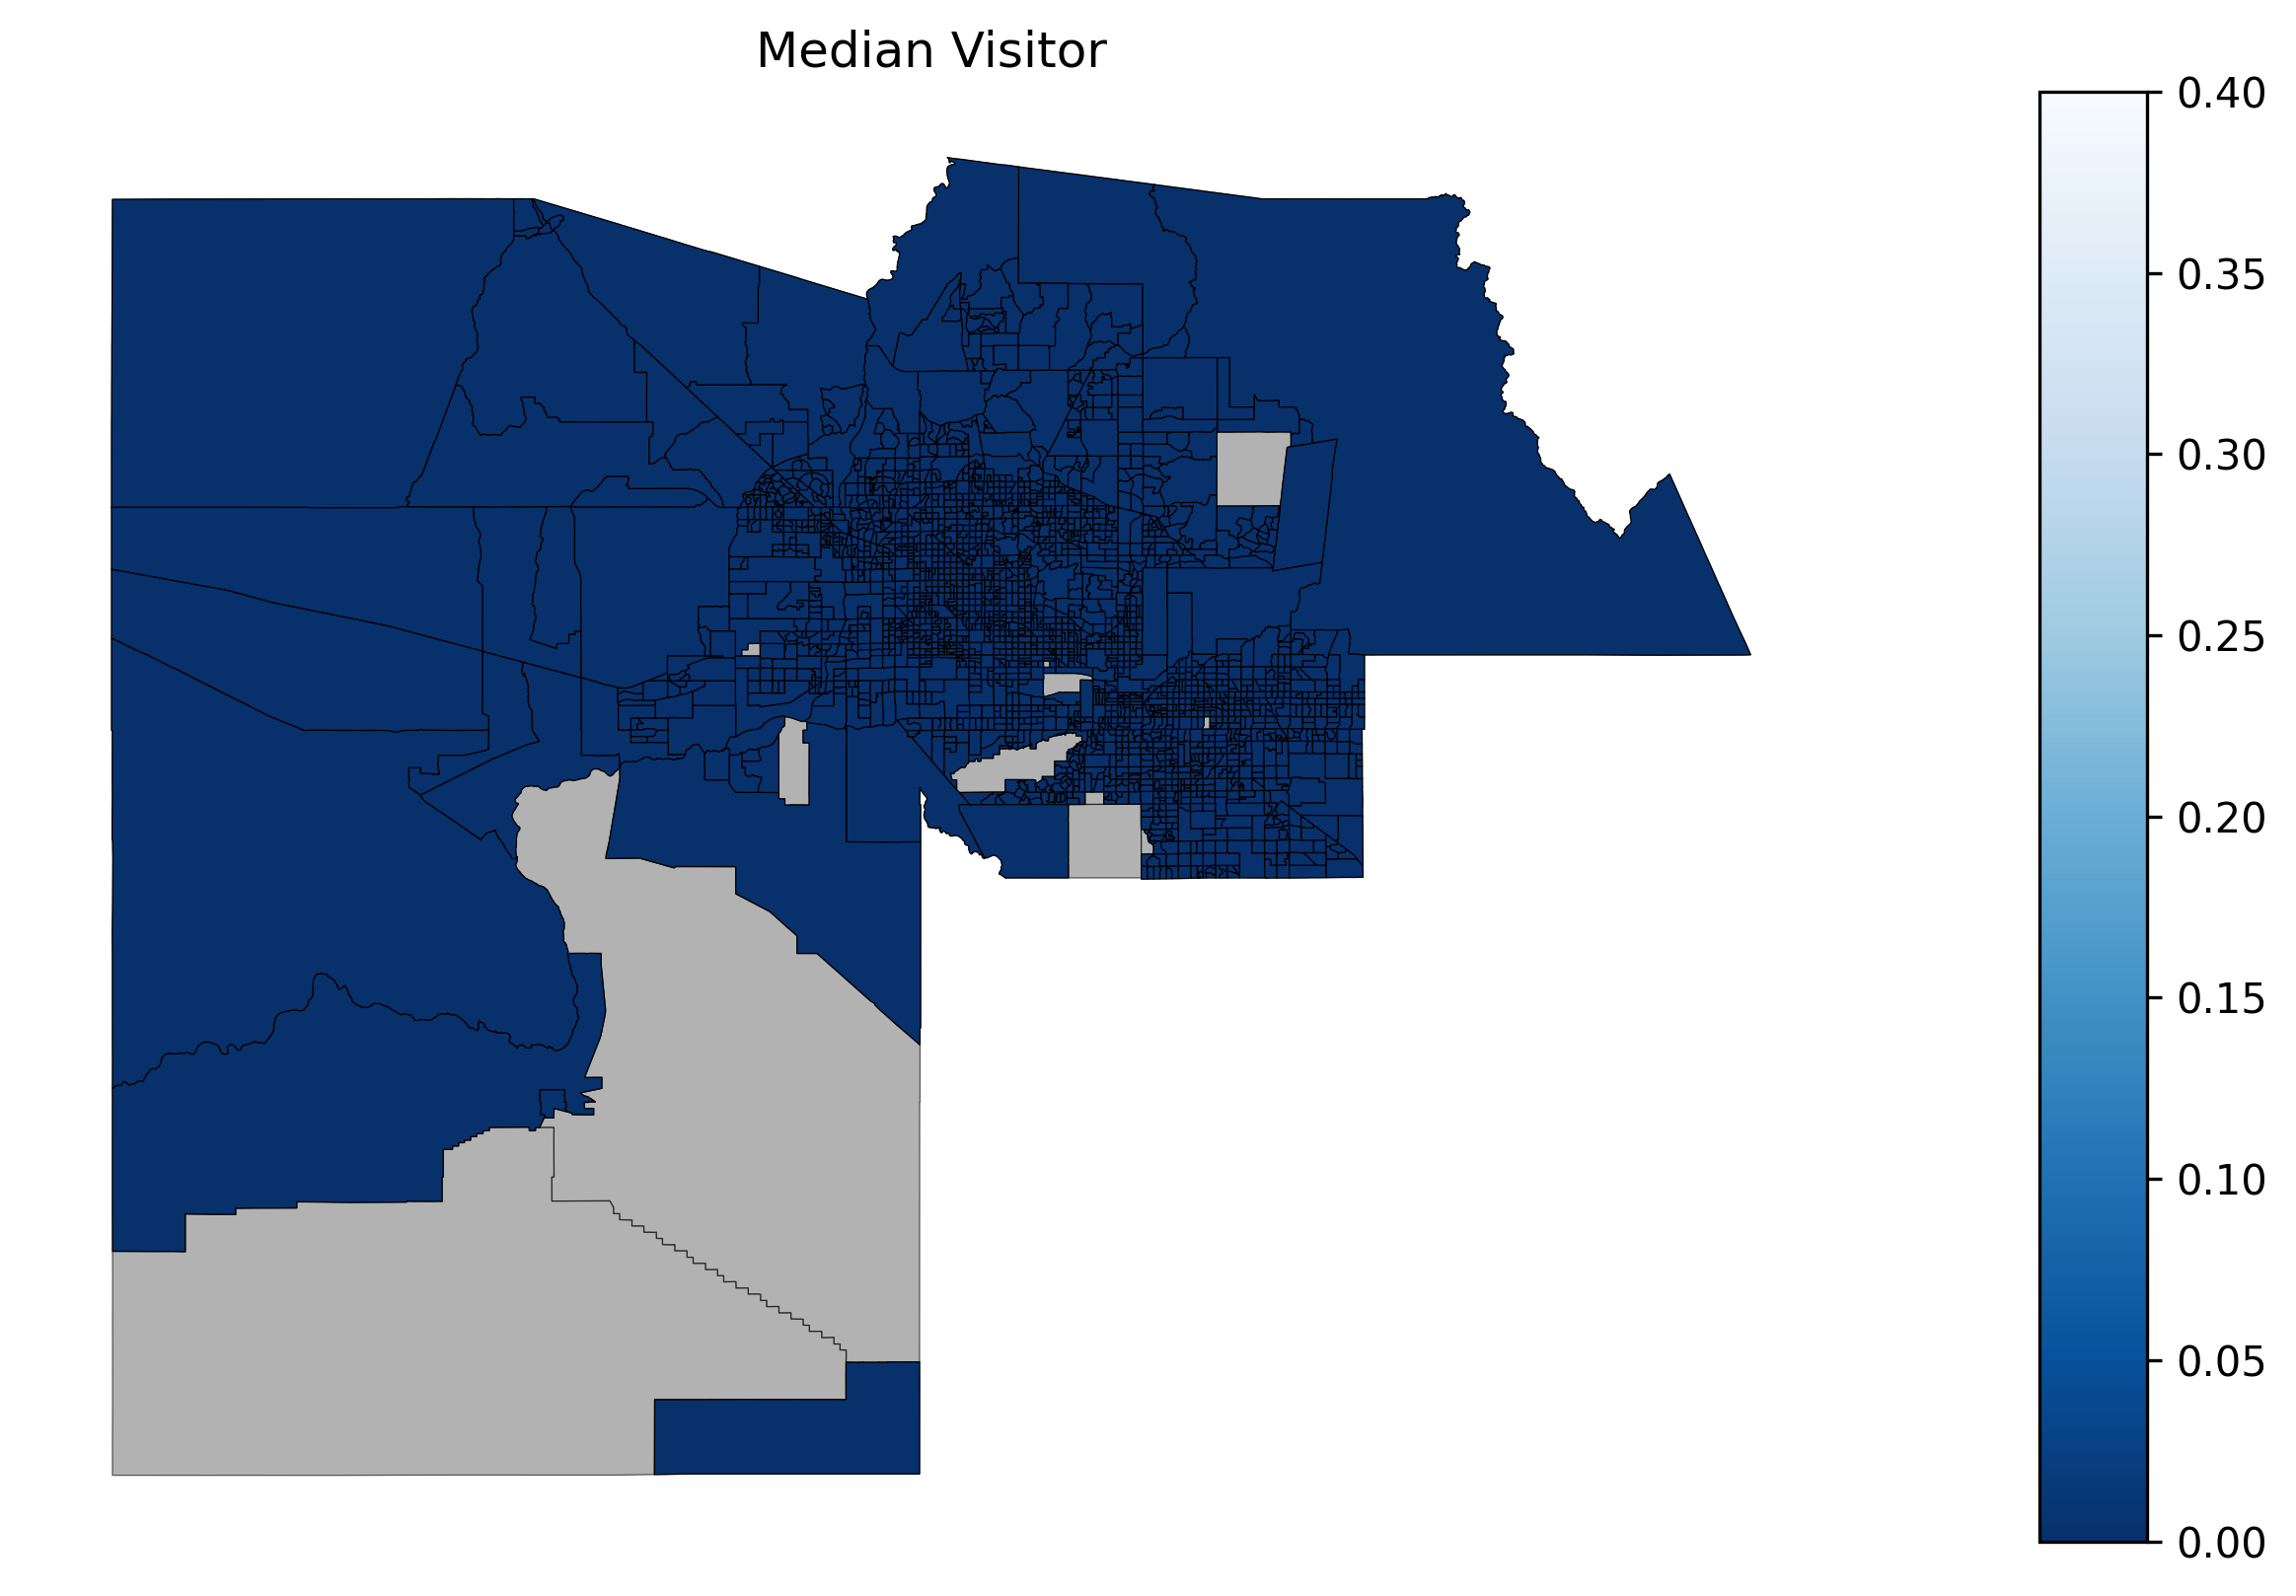

In [139]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set vmin and vmax for both plots
vmin = gpd_df_filtered[['mean visitor', 'median visitor']].min().min()
vmax = gpd_df_filtered[['mean visitor', 'median visitor']].max().max()

# Plot mean visitor
fig, ax1 = plt.subplots(figsize=(10, 10), dpi=300)
census_block_groups.plot(ax=ax1, linewidth=0.3, edgecolor='black', color='grey', alpha=0.6)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
gpd_df_filtered.plot(column='mean visitor', ax=ax1, legend=True, vmin=vmin, vmax=vmax, cmap="viridis", edgecolor='black', linewidth=0.3, cax=cax)
ax1.set_title('Mean Visitor')
ax1.axis('off')
plt.show()

# Plot median visitor
fig, ax2 = plt.subplots(figsize=(10, 10), dpi=300)
census_block_groups.plot(ax=ax2, linewidth=0.3, edgecolor='black', color='grey', alpha=0.6)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
gpd_df_filtered.plot(column='median visitor', ax=ax2, legend=True, vmin=vmin, vmax=vmax, cmap="viridis", edgecolor='black', linewidth=0.3, cax=cax)
ax2.set_title('Median Visitor')
ax2.axis('off')
plt.show()


In [113]:
import pandas as pd
import numpy as np
from scipy import stats
I want to exclude gpd_df['GEOID'] == '040134223021'
columns_to_analyze = [f'day {day}' for day in range(1, 31)]

gpd_df['mean visitor'] = gpd_df[columns_to_analyze].mean(axis=1)
gpd_df['median visitor'] = gpd_df[columns_to_analyze].median(axis=1)

gpd_df.head()

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      04      013  421702        3  040134217023  Block Group 3  G5030   
1      04      013  040531        2  040130405312  Block Group 2  G5030   
2      04      013  092312        1  040130923121  Block Group 1  G5030   
3      04      013  092721        1  040130927211  Block Group 1  G5030   
4      04      013  093104        1  040130931041  Block Group 1  G5030   

  FUNCSTAT    ALAND  AWATER  ... day 23 day 24 day 25 day 26  day 27  day 28  \
0        S   310375       0  ...      0      0      0      0       0       0   
1        S   616061       0  ...      0      0      0      0       0       0   
2        S   295623       0  ...      0      0      0      0       0       0   
3        S  1108648       0  ...      0      0      0      0       0       0   
4        S   168697       0  ...      0      0      0      0       0       0   

   day 29  day 30  mean visitor  median visitor  
0       0       0           0.0             0.0  
1       0       0           0.0             0.0  
2       0       0           0.0             0.0  
3       0       0           0.0             0.0  
4       0       0           0.0             0.0  

[5 rows x 46 columns]

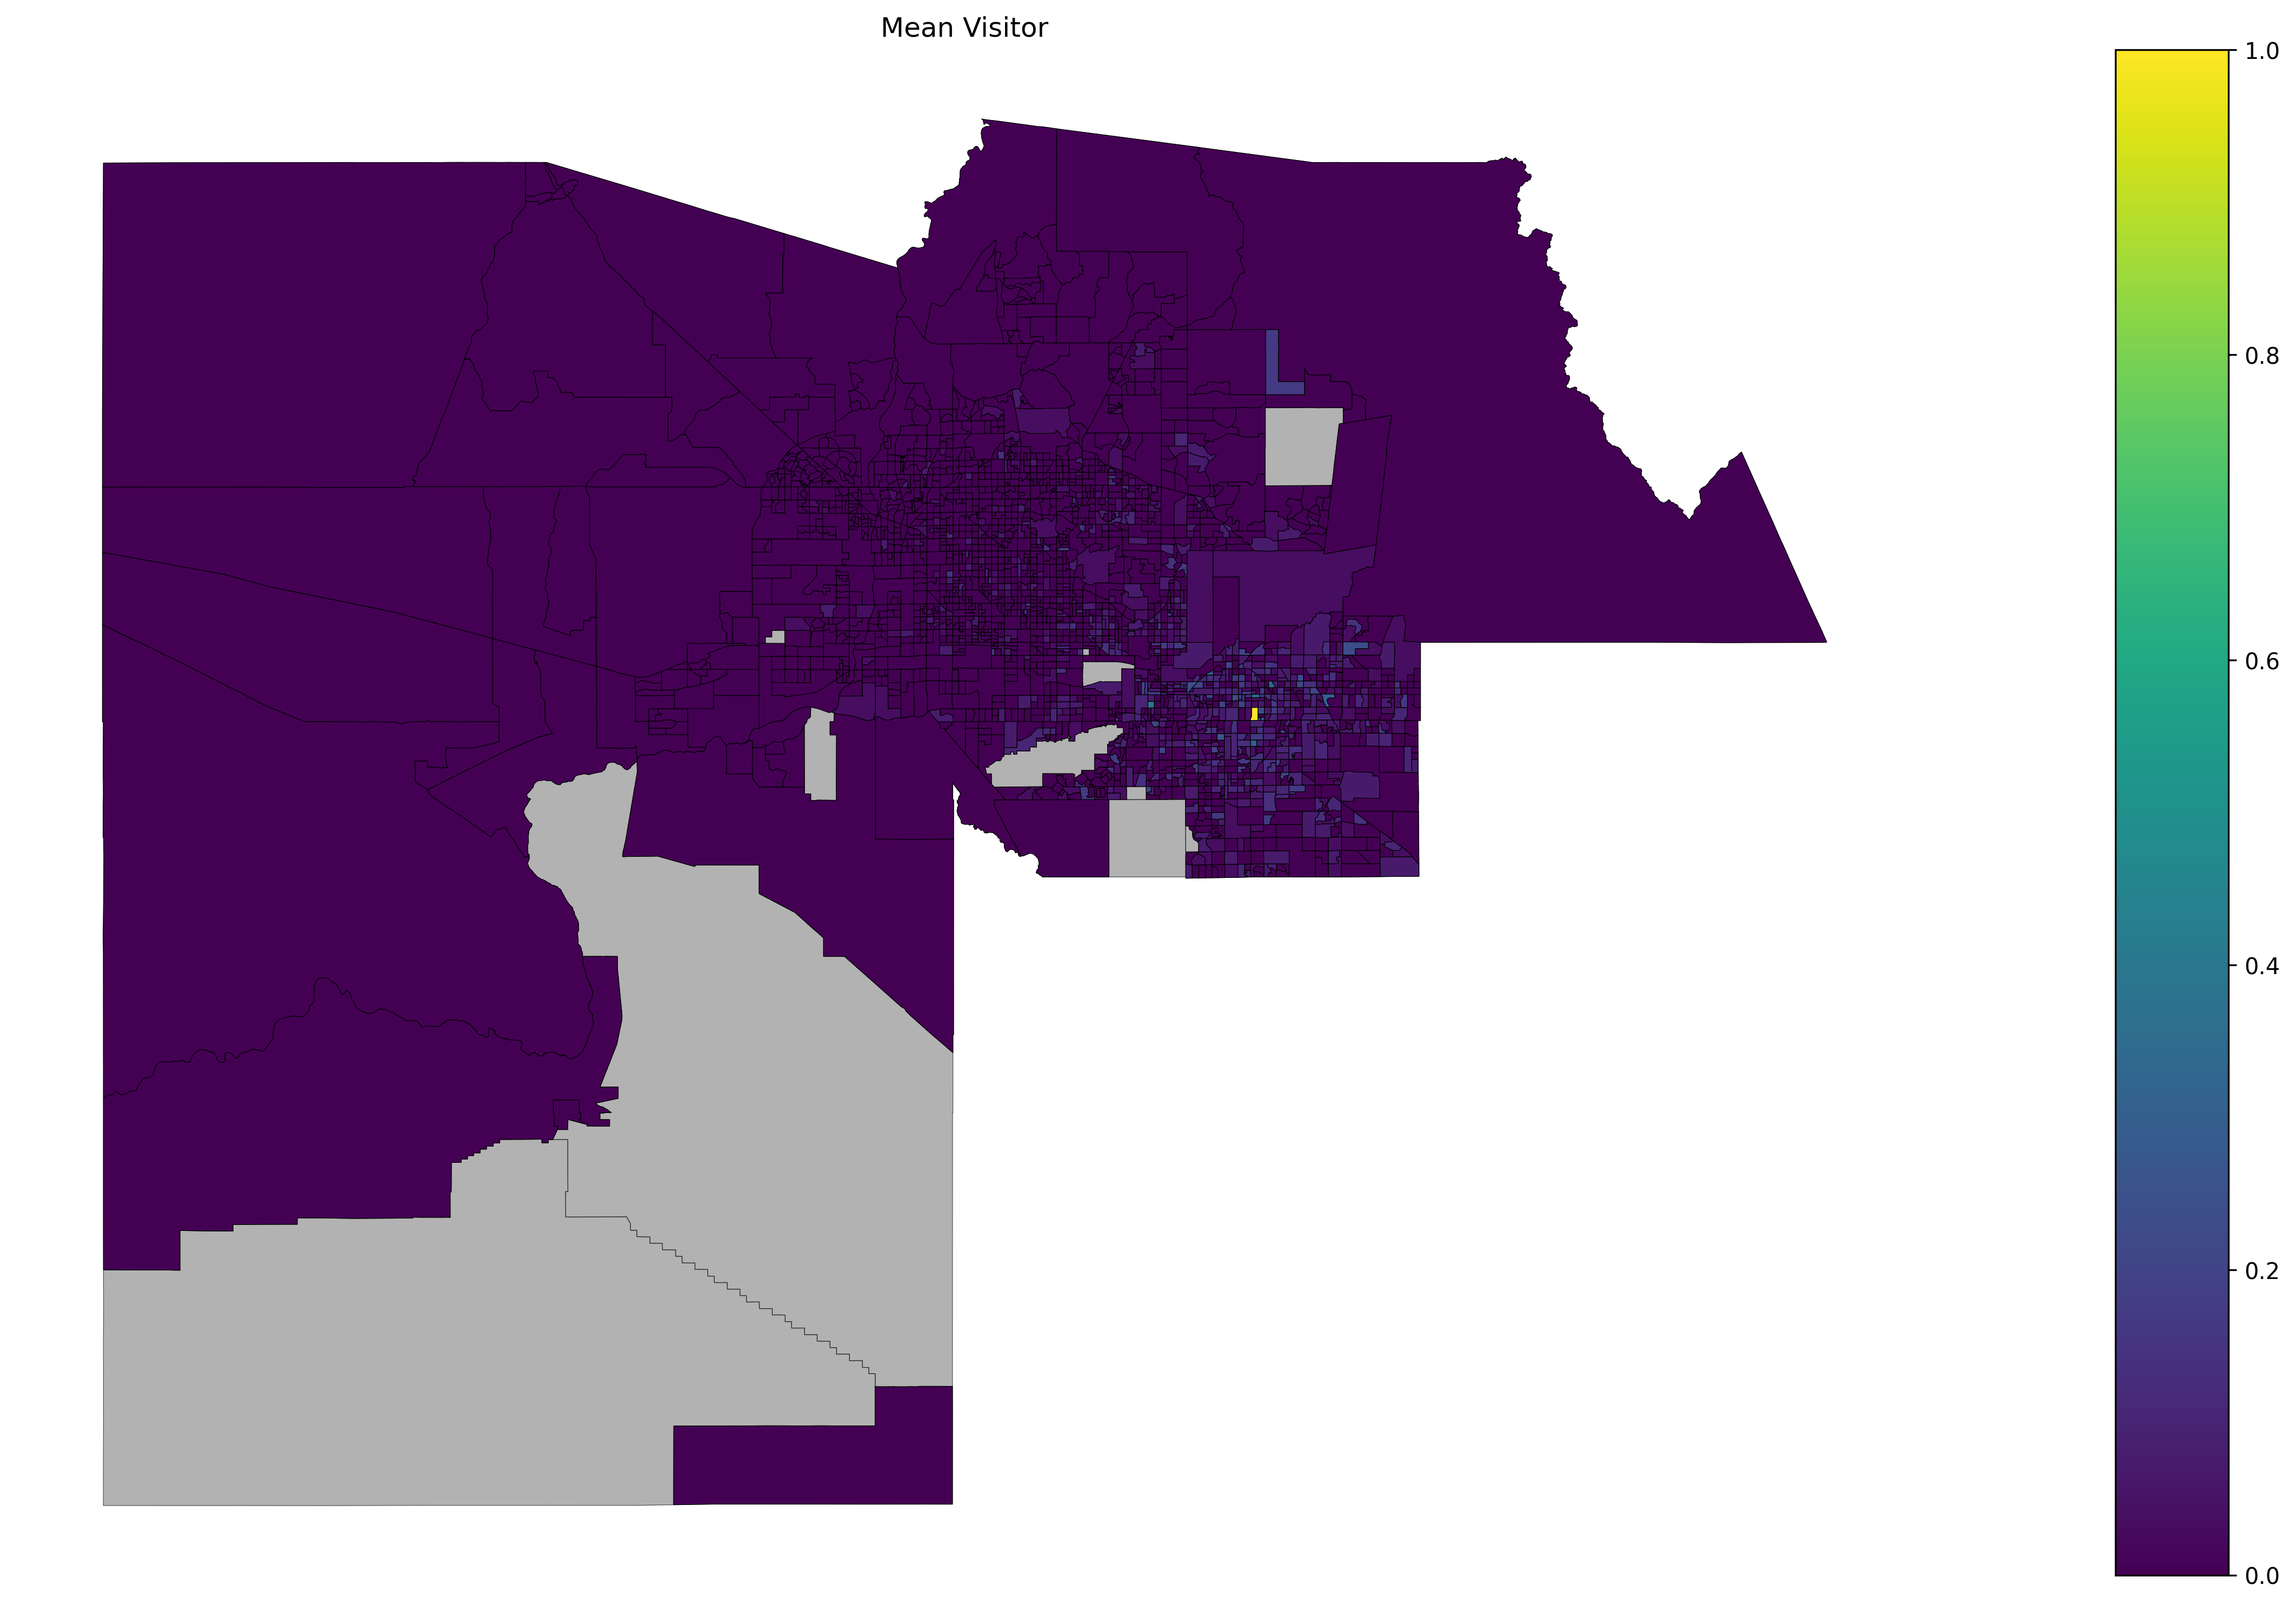

In [129]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set vmin and vmax for both plots
vmin = gpd_df[['mean visitor', 'median visitor']].min().min()
vmax = gpd_df[['mean visitor', 'median visitor']].max().max()

# Create subplots
fig, ax1 = plt.subplots(1, figsize=(20, 10), dpi=300)

# Plot mean visitor
census_block_groups.plot(ax=ax1, linewidth=0.3, edgecolor='black', color='grey', alpha=0.6)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
gpd_df.plot(column='mean visitor', ax=ax1, legend=True, vmin=vmin, vmax=1, cmap="viridis", edgecolor='black', linewidth=0.3, cax=cax)
ax1.set_title('Mean Visitor')
ax1.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
# Plot median visitor
census_block_groups.plot(ax=ax2, linewidth=0.3, edgecolor='black', color='grey', alpha=0.6)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
gpd_df.plot(column='median visitor', ax=ax2, legend=True, vmin=vmin, vmax=1, cmap="Blues_r", edgecolor='black', linewidth=0.3, cax=cax)
ax2.set_title('Median Visitor')
ax2.axis('off')

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from PIL import Image
import numpy as np

# Create temporary directory to store images
temp_dir = 'temp_images'
os.makedirs(temp_dir, exist_ok=True)

# Coordinates for the Stations and Trap
stations = [(4, 4), (4.5, 2), (2, 7), (6, 2)]
trap = (1, 1)

# Initial buffer radius and increment step
initial_radius = 1
increment_step = 0.1

# Frame settings
columns_to_animate = ['day ' + str(day) for day in range(1, 30)]
frames = []

# List to store radius increments
circle_list = np.arange(initial_radius, 10, increment_step)

# Function to check if the buffer reaches any station
def check_reached_station(trap, stations, radius):
    for station in stations:
        distance = np.sqrt((trap[0] - station[0])**2 + (trap[1] - station[1])**2)
        if distance <= radius:
            return True, station
    return False, None

# Function to check for nearby stations within 0.6 radius
def check_nearby_stations(trap, stations, radius):
    nearby_stations = [s for s in stations if np.sqrt((trap[0] - s[0])**2 + (trap[1] - s[1])**2) <= radius + 0.6]
    return nearby_stations

# Start creating frames
for column in columns_to_animate:
    fig, ax1 = plt.subplots(1, figsize=(10, 10))
    
    # Plot the initial trap and stations
    ax1.plot(*trap, 'bo', label='Trap')
    for station in stations:
        ax1.plot(*station, 'ro')
        ax1.text(station[0], station[1], ' Station', verticalalignment='bottom', horizontalalignment='right')

    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title(f'Buffer Expansion on {column}')
    ax1.axis('off')

    # Draw circles incrementally
    reached_any_station = False
    for radius in circle_list:
        circle = Circle(trap, radius, color='b', fill=False, linestyle='dotted')
        ax1.add_patch(circle)
        
        reached, station = check_reached_station(trap, stations, radius)
        if reached:
            ax1.plot(*station, 'go')  # Mark the reached station
            ax1.text(station[0], station[1], ' Reached', verticalalignment='top', horizontalalignment='left', color='green')
            stations.remove(station)  # Remove the reached station from the list
            reached_any_station = True

        if reached_any_station:
            nearby_stations = check_nearby_stations(trap, stations, radius)
            if not nearby_stations:
                break

    img_file = os.path.join(temp_dir, f'day_{column[4:]}.png')
    plt.savefig(img_file, dpi=200, bbox_inches='tight')
    plt.close(fig)

    frames.append(Image.open(img_file))

# Save the frames as a GIF
gif_path = 'buffer_expansion.gif'
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0
)

# Cleanup temporary images
for img_file in os.listdir(temp_dir):
    file_path = os.path.join(temp_dir, img_file)
    os.remove(file_path)

os.rmdir(temp_dir)

print(f'Animation saved as {gif_path}')




Animation saved as buffer_expansion.gif


In [50]:
gif_path

'/Users/alexandernez/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/gifs/infected.gif'